# DSRM Final Project 213886

## Introduction

In this notebook I aim to manipulate the data provided in order to try and determine what type and the amount of physical activity performed by certain subjects. Data is provided on all subjects 1-9 in the protocol folder but there is additional data provided only for subjects 1, 5, 6, 8 and 9 in the optional folder.

9 subjects taken part. 3 IMU sensors worn on the ankle, chest and hand which each record gyroscopic, magnetometer, acceleration data and temperature data. They have a sampling frequency of 100Hz. Subjects also wear a heart rate monitor with a sampling frequency of 9Hz. Subjects perform a range different activities such as lying, cycling, running, driving etc. No subjects perform all activities, meaning there is some inconsistency in the data. 

Activity id's and their respective activities are described in the readme pdf file that is provided with the data. Some activity id numbers are skipped such as activity id 8, 14, 15, 21, 22 and 23.


## Importing and cleaning

First we import our core modules that we need. We then import all of our dataframes. We then aim to clean our data so that we can start exploring relationships between variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pylab
from scipy import stats
warnings.filterwarnings('ignore') #Importing data provides warnings which are not useful. 

As a note to the reader, please import the optional data in the same way as the protocol data but with an "opt" at the start of the filename. This is because the data included in the optional and protocol folders are named the same and so would therefore be confusing.

In [2]:
#Importing the data
for i in range(1,10):
    exec(f'sub{i} = pd.read_csv("subject10{i}.dat", sep="\s+", header=None)')
    
# Now the same for the optional data sets 
subjects = [1,5,6,8,9]
for i in subjects:
    exec(f'optsub{i} = pd.read_csv("optsubject10{i}.dat", sep="\s+", header=None)')

In [3]:
sub1.head(3) #Printing uncleaned DataFrame

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0


Our DataFrames are very messy. We now need to rename all of our columns to what they should be as described in the readme. 

In [4]:
columns = ["timestamp", "activityid", "heart_rate", "hand_temp", "hand16_1", "hand16_2", "hand16_3", "hand6_1", "hand6_2", "hand6_3", "handgyro1", "handgyro2", "handgyro3", "handmagnet1", "handmagnet2", "handmagnet3", "handorientation1", "handorientation2", "handorientation3", "handorientation4", "chest_temp", "chest16_1", "chest16_2", "chest16_3", "chest6_1", "chest6_2", "chest6_3", "chestgyro1", "chestgyro2", "chestgyro3", "chestmagnet1", "chestmagnet2", "chestmagnet3", "chestorientation1", "chestorientation2", "chestorientation3", "chestorientation4", "ankle_temp", "ankle16_1", "ankle16_2", "ankle16_3", "ankle6_1", "ankle6_2", "ankle6_3", "anklegyro1", "anklegyro2", "anklegyro3", "anklemagnet1", "anklemagnet2", "anklemagnet3", "ankleorientation1", "ankleorientation2", "ankleorientation3", "ankleorientation4"]
n = 10
for i in range(1,n):
    eval("sub"+str(i)).columns = columns #Looping over all dataframes.
    
optsub1.columns = columns
optsub5.columns = columns
optsub6.columns = columns
optsub8.columns = columns
optsub9.columns = columns

We then discard all of our data labeled with activityID = 0 as this data covers transient movement that takes place between the activities we are concerned with and so may be misleading. This is advised in the readme provided with the original data. 

Looping over DataFrames proved to be quite difficult, with many usual dictionary methods not working and so I decided to use .drop() instead.

In [5]:
for df in sub1, sub2, sub3, sub4, sub5, sub6, sub7, sub8, sub9, optsub1, optsub5, optsub6, optsub8, optsub9:
    df.drop(df.index[df["activityid"] == 0],axis=0,inplace=True) #Specifying axis = 0 as this refers to columns.

We now aim to collate our protocol and optional data provided for the subjects that have optional data. However, the timestamp's overlap across the two sets of data for each subject whereby it might look like multiple activities were being performed at once.

To fix this, we take the last timestamp of the subjects protocol data and add 0.01 (our time interval). We then add this value to every timestamp in the optional data and subtract the first time stamp from these new values. This gives a continuous stream of time that carries on from our protocol to our optional DataFrames for each applicable subject.

For subject9, the optional data is much larger than that of the protocol data (which is not the case for subjects 1, 5, 6 and 8) and so the first timestamp in the optional data has a larger value than that of the last timestamp in the protocol data. Hence our correcttimes function does not work in this case as it will give negative times in the optional data. For this case we do it manually.

In [6]:
def correcttimes(prot, opt):
    difference = prot.iloc[-1,0] + 0.01
    opt.timestamp = opt.timestamp + difference - opt.iloc[0,0]
    
values = [1,5,6,8]
for i in values:
    correcttimes(eval("sub"+str(i)), eval("optsub"+str(i)))

#sub9
difference9 = sub9.iloc[-1,0] + 0.01
optsub9.timestamp = optsub9.timestamp - optsub9.iloc[0,0] + difference9

Now that the timestamp's are continuous across the protocol and optional data for the applicable subjects, we can concatenate these datasets into one. 

In [7]:
sub1 = pd.concat([sub1, optsub1])
sub5 = pd.concat([sub5, optsub5])
sub6 = pd.concat([sub6, optsub6])
sub8 = pd.concat([sub8, optsub8])
sub9 = pd.concat([sub9, optsub9])

We can check that there is no overlap in activities performed over time by plotting timestamp against activity id. The data should be broken up by time and should form a solid straight line if all brought together on the y-axis. There should also be no time periods whereby two activities are being performed. We will plot this now.

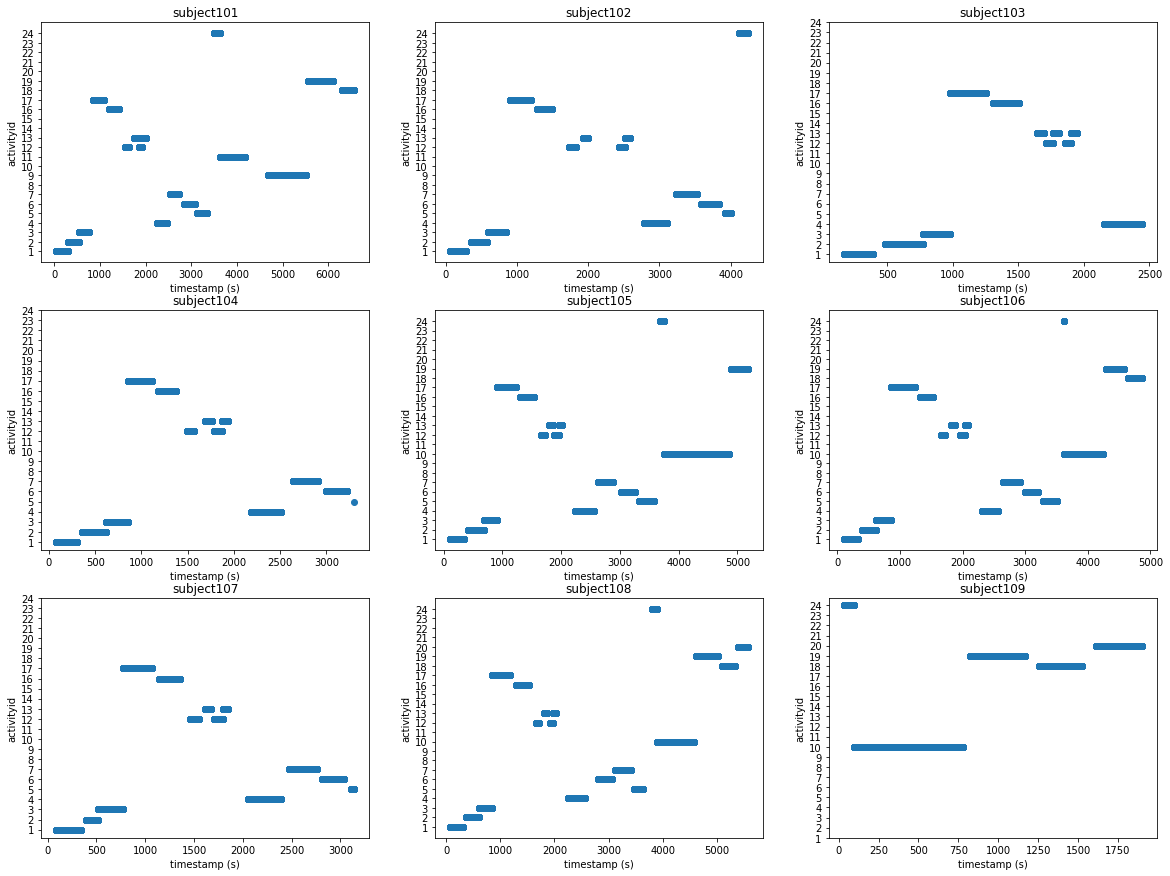

In [8]:
fig = plt.figure(figsize = (20,15))
    
for i in range(1,10):
    exec(f'ax{i} = fig.add_subplot(33{i})')
    exec(f'timestamp{i} = sub{i}.timestamp')
    exec(f'activityid{i} = sub{i}.activityid')
    eval("ax"+str(i)).scatter(eval("timestamp"+str(i)), eval("activityid"+str(i)))
    eval("ax"+str(i)).set_xlabel("timestamp (s)")
    eval("ax"+str(i)).set_ylabel("activityid")
    eval("ax"+str(i)).set_title("subject10"+str(i))
    eval("ax"+str(i)).set_yticks(np.arange(1,25), minor=False)

We can see that there is no overlap where two activities are being performed at once and so our times are correct.

We now remove the 3D-acceleration data with the $+/-$6g scale as it is not precisely calibrated with the $+/-$16g. It also gets saturated sometimes by certain movements (e.g. running) as detailed in the readme file. We also remove the orientation as this is specified to be invalid.

In [9]:
def remove(df):
    df = df.drop(["hand6_1", "hand6_2", "hand6_3", "chest6_1", "chest6_2", "chest6_3", "ankle6_1", "ankle6_2", "ankle6_3", "ankleorientation1", "ankleorientation2", "ankleorientation3", "ankleorientation4", "chestorientation1", "chestorientation2", "chestorientation3", "chestorientation4", "handorientation1", "handorientation2", "handorientation3", "handorientation4"], axis = 1, inplace = True)
    
for i in range(1,10):
    remove(eval("sub"+str(i)))

In [10]:
sub1.head(3)

,timestamp,activityid,heart_rate,hand_temp,hand16_1,hand16_2,hand16_3,handgyro1,handgyro2,handgyro3,...,ankle_temp,ankle16_1,ankle16_2,ankle16_3,anklegyro1,anklegyro2,anklegyro3,anklemagnet1,anklemagnet2,anklemagnet3
2928,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,30.75,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
2929,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,30.75,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2930,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,30.75,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119


Now that the data is cleaned thoroughly, we can proceed to do some exploratory data analysis.

## Exploratory data analysis

Originally, I carried out very thorough exploratory data analysis. However, I have found that some of the relationships I have explored have been quite useless in the grand scheme of the report. Hence I will include some of them in the appendix instead of the main report for brevity. We want to mainly focus on heart rate as an indicator of exercise and so relationships such as temperature and activity that don't eventually offer any contribution are omitted.

We use the exec and eval functions heavily from now on as these prove to be very useful when plotting a large amount of graphs. Also, due to the fact that we are working with 9 DataFrames, this means that we need a way to quickly assign variables for each column for each subject.

### Heart rate against activity 

We now aim to plot the heart rate for each activity for each subject. This is so that we can see which activities are most affected by heart rate and to check if heart rate is still a good enough indicator to use in the later modelling section. Of course we would expect that activities with a high amount of movement such as running (activity 5), playing soccer (activity 20) and rope-jumping (activity 24) will have the highest maximum heart rates.

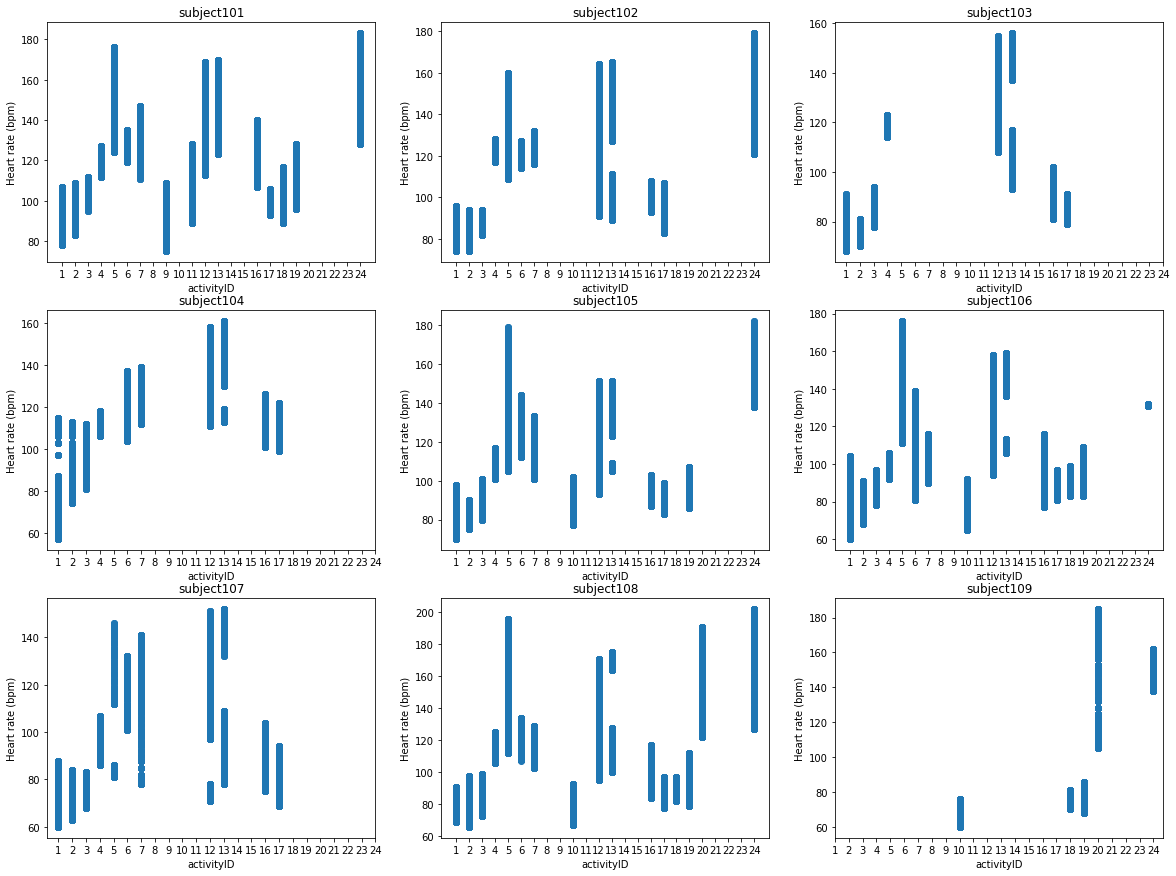

In [11]:
fig = plt.figure(figsize = (20,15))
for i in range(1,10):
    exec(f'ax{i} = fig.add_subplot(33{i})')
    exec(f'heart_rate{i} = sub{i}.heart_rate') #Assigning each heart rate column for each subject to an array 
    eval("ax"+str(i)).scatter(eval("activityid"+str(i)), eval("heart_rate"+str(i)))
    eval("ax"+str(i)).set_xticks(np.arange(1,25), minor=False)
    eval("ax"+str(i)).set_xlabel("activityID")
    eval("ax"+str(i)).set_ylabel("Heart rate (bpm)")
    eval("ax"+str(i)).set_title("subject10"+str(i))

These plots support our previous claim that high movement activities produce the highest levels of heart rate as we would expect, with activities 5 (running), 12 (ascending stairs), 20 (soccer), 24 (rope jumping) being the most significant. Of course, on the other end of the spectrum, activities such as 1 (lying), 2 (sitting) and 10 (computer work) do not cause the subjects heart rate to increase much above their resting heart rate. The plots also show that generally heart rate is a good indicator of the amount and strenuity of exercise taken place by subjects as there are no real outliers.

I am now interested in how heart rate changes over time for each of the subjects. It is important to note that subjects do not perform activities in order of physical activity/movement and so I'm expecting the data to have numerous breaks and large fluctuations.

### Heart rate over time

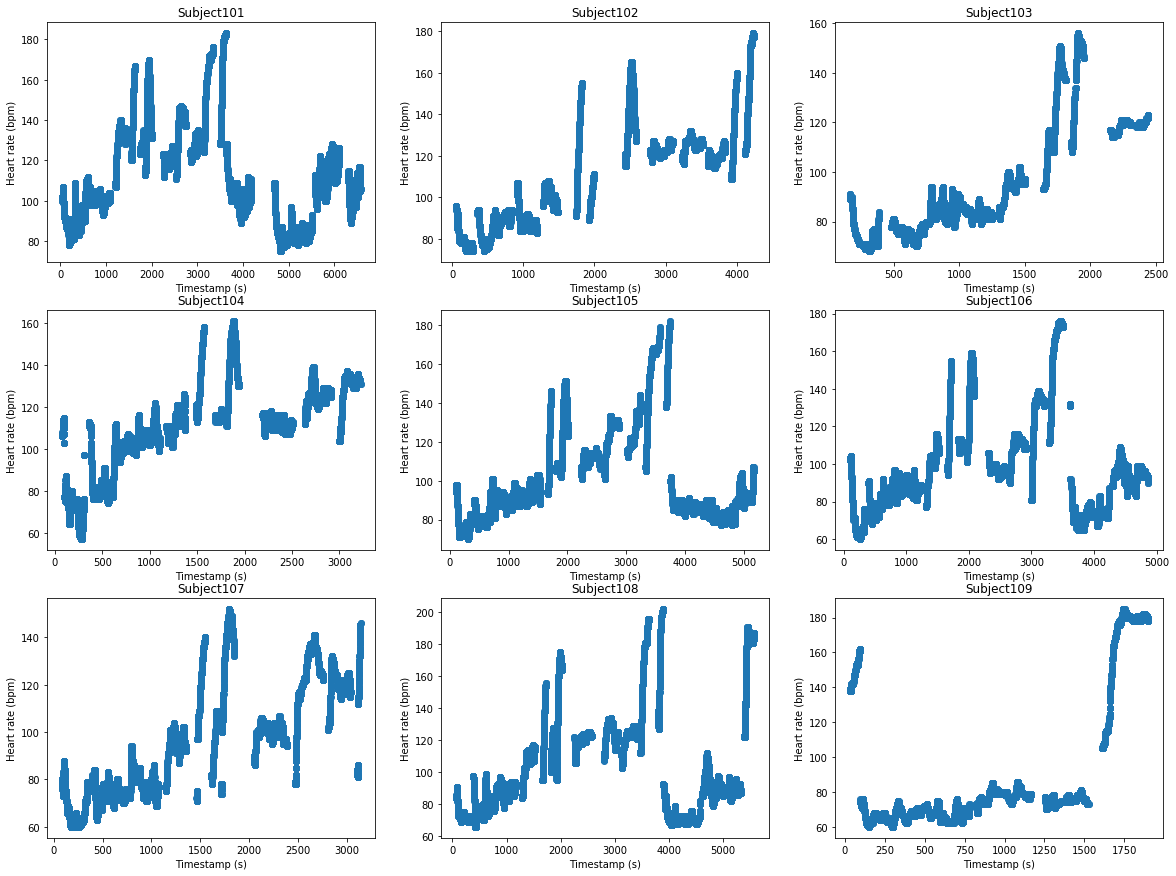

In [12]:
fig = plt.figure(figsize = (20,15))
for i in range(1,10):
    exec(f'ax{i} = fig.add_subplot(33{i})')
    exec(f'timestamp{i} = sub{i}.timestamp') #Assigning each timestamp column for each subject to an array.
    eval("ax"+str(i)).scatter(eval("timestamp"+str(i)), eval("heart_rate"+str(i)))
    eval("ax"+str(i)).set_xlabel("Timestamp (s)")
    eval("ax"+str(i)).set_ylabel("Heart rate (bpm)")
    eval("ax"+str(i)).set_title("Subject10"+str(i))

Considering that activity is not included in these plots, it might be useful to try and use clustering across these plots in the hopes of classifying activities performed. A successful approach would allow me to predict what activity is being performed at a certain time for each subject. We will explore this further later on in the project.

### Acceleration during activities

We now take a break from heart rate and conduct some exploration centred around the acceleration data provided. This is because we will use it later on in our models to test the suitability when compared to heart rate as an indicator for exercise. We would assume like heart rate that the more physically demanding activities produce higher rates of acceleration as there is more movement involved.

We first want to plot the x, y, and z components of hand acceleration to see the contribution that each direction has on the overall acceleration and to see if acceleration is worth exploring.

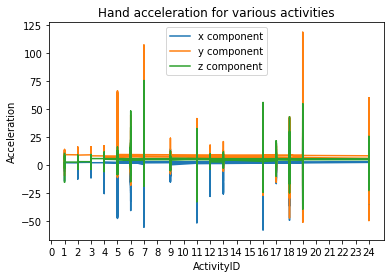

In [13]:
#Plotting the x,y,z components of hand acceleration for the different activities.
sub1handx = sub1.hand16_1
sub1handy = sub1.hand16_2
sub1handz = sub1.hand16_3

plt.plot(activityid1, sub1handx, label = "x component")
plt.plot(activityid1, sub1handy, label = "y component")
plt.plot(activityid1, sub1handz, label = "z component")
plt.xticks(np.arange(0,25))
plt.xlabel("ActivityID")
plt.ylabel("Acceleration")
plt.title("Hand acceleration for various activities")
plt.legend(loc = "upper center")
plt.show()

We can see that activities with the highest hand acceleration are activity 7 (nordic walking) and 19 (house cleaning). These are results that we should expect as these activities involve alot of hand movement and so we will continue with exploratory data analysis for acceleration.

Accelerometers however do not take into account the effect gravity has on acceleration. We adjust for this below by removing 1G (9.9 $ms^{-2}$) from our resultant acceleration. We find this resultant acceleration by taking the Euclidian norm of the accelerations across the x,y,z components respectively with the formula:

$A=\sqrt{(X^2+Y^2+Z^2)}$

In [14]:
def acceleration(x,y,z):
    acceleration = np.sqrt(x**2 + y**2 + z**2)
    resultantacc = acceleration - 9.8
    return resultantacc #Removing acceleration due to gravity.

We need to create nine arrays for each subject, totaling 81 arrays for all subjects and so exec helps us do this quickly. 

In [15]:
#hand acceleration
for x in range(1,10):
    exec(f'sub{x}handx = sub{x}.hand16_1')
    exec(f'sub{x}handy = sub{x}.hand16_2')
    exec(f'sub{x}handz = sub{x}.hand16_3')
    exec(f'accelerationhand{x} = acceleration(sub{x}handx, sub{x}handy, sub{x}handz)')

In [16]:
#chest acceleration
for x in range(1,10):
    exec(f'sub{x}chestx = sub{x}.chest16_1')
    exec(f'sub{x}chesty = sub{x}.chest16_2')
    exec(f'sub{x}chestz = sub{x}.chest16_3')
    exec(f'accelerationchest{x} = acceleration(sub{x}chestx, sub{x}chesty, sub{x}chestz)')

In [17]:
#ankle acceleration
for x in range(1,10):
    exec(f'sub{x}anklex = sub{x}.ankle16_1')
    exec(f'sub{x}ankley = sub{x}.ankle16_2')
    exec(f'sub{x}anklez = sub{x}.ankle16_3')
    exec(f'accelerationankle{x} = acceleration(sub{x}anklex, sub{x}ankley, sub{x}anklez)')

In [18]:
for x in range(1,10): #Averaging acceleration across hand, chest and ankle.
    exec(f'meanacceleration{x} = (accelerationankle{x} + accelerationchest{x} + accelerationhand{x})/3')

We are now going to plot the activityid against the mean acceleration across the hand, chest and ankle for each of the subjects.

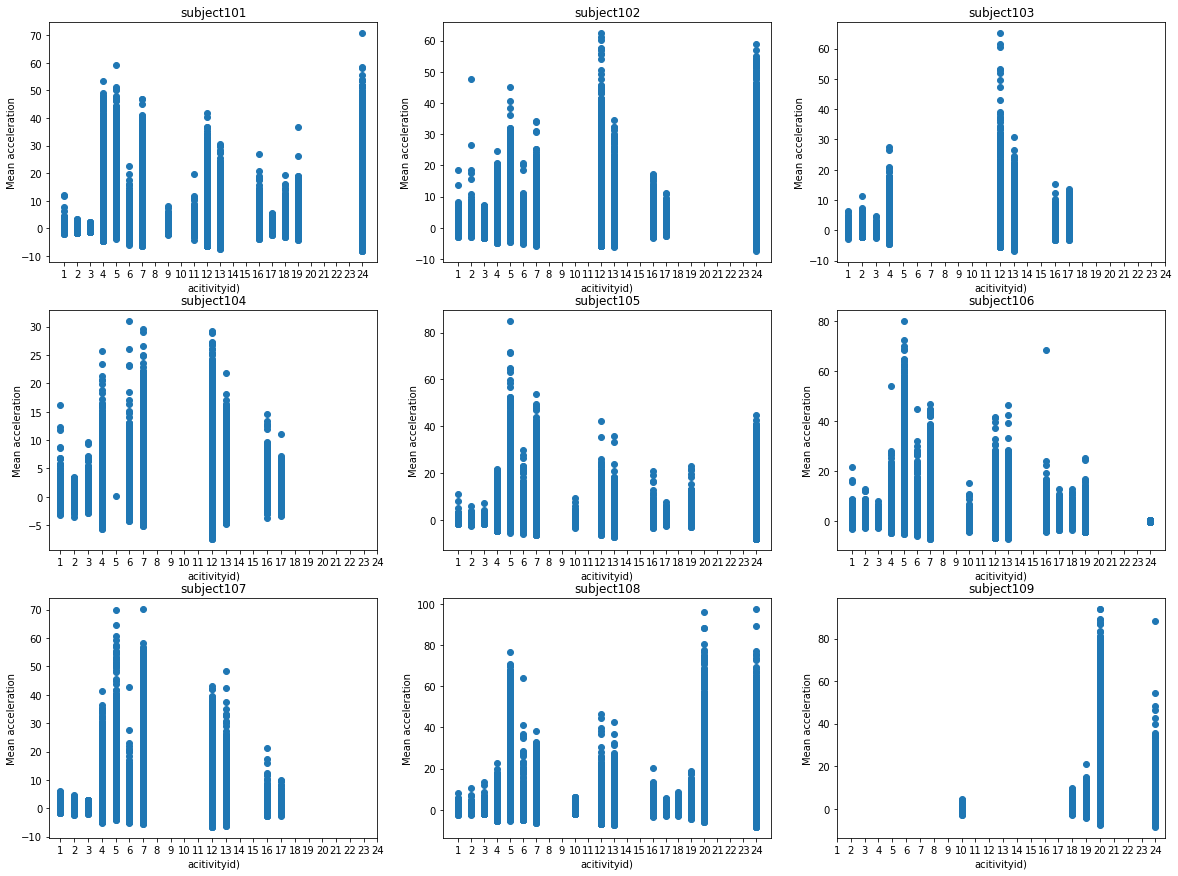

In [19]:
fig = plt.figure(figsize = (20,15))
for x in range(1,10):
    exec(f'ax{x} = fig.add_subplot(33{x})')

for i in range(1,10):
    eval("ax"+str(i)).scatter(eval("activityid"+str(i)), eval("meanacceleration"+str(i)))
    eval("ax"+str(i)).set_xlabel("acitivityid)")
    eval("ax"+str(i)).set_ylabel("Mean acceleration")
    eval("ax"+str(i)).set_title("subject10"+str(i))
    eval("ax"+str(i)).set_xticks(np.arange(1,25), minor=False)

We can see that results are what we were expecting, with high-movement activities such as activity 5 (running) generally having the highest maximum acceleration while low-movement activities such as activity 1 (lying) has one of the lowest maximum accelerations.

# Hypothesis testing

We now want to do some hypothesis testing to see the difference in heart rates between different activities across our subjects. Even though this can be seen on the previous plots, we want to see the significance of the difference statistically.

We will choose three activities whereby the first involves little to no movement, the second involves a moderate amount of activity and the last activity is very physically strenuous for the subject. 


We must choose activities that a large proportion of the subjects have undertaken so that our results are more significant. We choose activity 1 (lying) as our first activity, activity 4 (walking) as our second and activity 12 (ascending stairs) as our most strenuous activity.

I have chosen these activities as there is clearly going to be a difference in the subject's heart rates across these three activities and 8/9 of the subject's took part in all of them. This means we maintain consistency across our results, avoiding using different subjects for each of our three chosen activities. 

However, it is important to note that there are many missing values for heart rate. In the readme this is explained as being due to the fact that sampling is given every 0.01s (100Hz) whereas the frequency of the heart rate monitor was only 9Hz. This means we miss a large amount of the potential data and so it may be better to use acceleration in the future due to the higher sample size. Regardless, we stil have a high sample size of heart rate for each subject which is very useful as it means the results of our tests are less likely due to chance.

## Plots

Before we do any hypothesis testing, we want to look at how heart rate changes with time for our chosen activities.

We now plot this for each subject for our first chosen activity - lying. 

### Activity 1 (lying)

In [20]:
for i in range(1,9):  #Creating the needed variables.
    exec(f'sub{i}_activity1 = sub{i}[sub{i}.activityid == 1]')
    exec(f'hr_activity1_sub{i} = sub{i}_activity1["heart_rate"]')
    exec(f'time_activity1_sub{i} = sub{i}_activity1["timestamp"]')

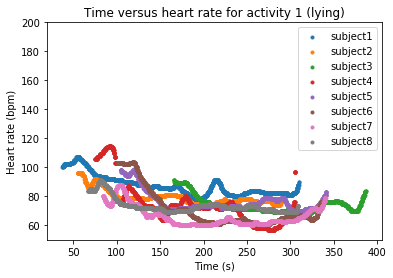

In [21]:
fig = plt.figure() #Subject 9 is the only one who does not participate.
ax = fig.add_subplot(111)
for i in range(1,9):
    ax.scatter(eval("time_activity1_sub"+str(i)), eval("hr_activity1_sub"+str(i)), label = "subject"+str(i), marker = ".")
    ax.set_ylim(50,200)
    ax.set_ylabel("Heart rate (bpm)")
    ax.set_xlabel("Time (s)")
    ax.set_title("Time versus heart rate for activity 1 (lying)")
    ax.legend()

Our results are as expected, with the heart rate over time being very low. Values are very similar to that of the resting heart rate of each subject which shows it is a very low-intensity activity.

### Activity 4 (walking)

In [22]:
for i in range(1,9):
    exec(f'sub{i}_activity4 = sub{i}[sub{i}.activityid == 4]')
    exec(f'hr_activity4_sub{i} = sub{i}_activity4["heart_rate"]')
    exec(f'time_activity4_sub{i} = sub{i}_activity4["timestamp"]')
    exec(f'time_activity4_sub{i} = time_activity4_sub{i} - time_activity4_sub{i}.iloc[0]')
    #Setting times to start at 0 instead of 2000-3000s. Didn't need to do for lying as first activity performed by all subjects.

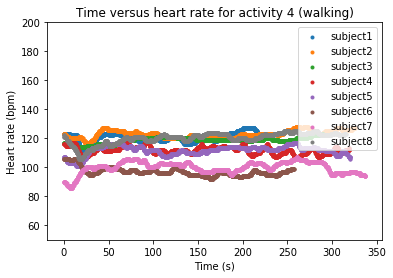

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(1,9):
    ax.scatter(eval("time_activity4_sub"+str(i)), eval("hr_activity4_sub"+str(i)), label = "subject"+str(i), marker = ".")
    ax.set_ylim(50,200)
    ax.set_ylabel("Heart rate (bpm)")
    ax.set_xlabel("Time (s)")
    ax.set_title("Time versus heart rate for activity 4 (walking)")
    ax.legend()

It seems that walking produces a higher heart rate than lying for all subjects. It seems around 20bpm higher than lying on average which is what we would expect.

Originally I plotted the same for activity 12 (ascending stairs) but unfortunately it seems that many of the subjects performed the activity for a little while and then stopped shortly, resuming later on. This does not give good results and so I opted to pick another highly strenuous activity instead. I will include the plot in the appendix. 

Activity 5 (running) seems like the next best alternative. However, it is unfortunate that only subjects 1, 2, 5, 6, 7 and 8 perform this activity as we would prefer if the same subjects were being used every time for integrity of results. The fact that the individual subjects do not all perform the same activity is a huge flaw in the data and makes it hard to work with. Ideally, all subjects would perform all 24 activities for the same amount of time but unfortunately this is not true.

### Activity 5 (running)

In [24]:
subjects = [1,2,5,6,7,8]
for i in subjects:
    exec(f'sub{i}_activity5 = sub{i}[sub{i}.activityid == 5]')
    exec(f'hr_activity5_sub{i} = sub{i}_activity5["heart_rate"]')
    exec(f'time_activity5_sub{i} = sub{i}_activity5["timestamp"]')   
    exec(f'time_activity5_sub{i} = time_activity5_sub{i} - time_activity5_sub{i}.iloc[0]') #Again setting time to start at 0.

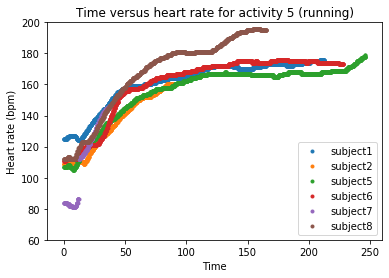

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in subjects:
    ax.scatter(eval("time_activity5_sub"+str(i)), eval("hr_activity5_sub"+str(i)), label = "subject"+str(i), marker = ".")
    ax.set_ylim(60,200)
    ax.set_ylabel("Heart rate (bpm)")
    ax.set_xlabel("Time")
    ax.set_title("Time versus heart rate for activity 5 (running)")
    ax.legend()

Running produces a much better plot than ascending stairs and so we will go with this instead. Heart rates for running for applicable subjects are much higher than that of walking and lying, with it reaching almost 200bpm for subject108.

## Normality checks

Before we do any statistical tests, we need to investigate if the distribution of heart rate values deviates from a normal distribution for each subject for each of our chosen activities. We do this first with activity 4 (walking) by plotting histograms of heart rate for each subject. If the distribution was normal we would see a faint bell curve. 

In the appendix I have included the histograms and Q-Q plots for the other activities we are investigating and I will only leave the Shapiro-Wilk tests for these activities in the main project.

### Histograms

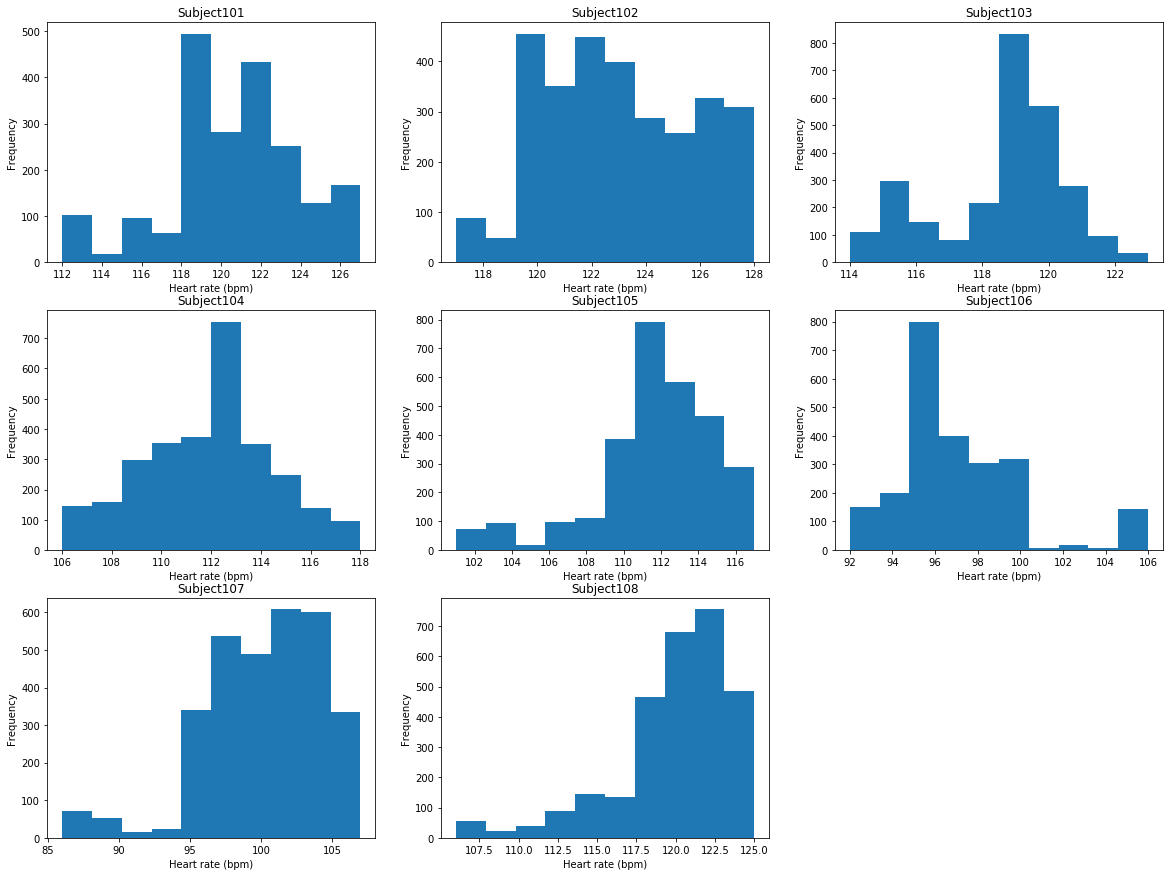

In [26]:
fig = plt.figure(figsize = (20,15))
for i in range(1,9):
    exec(f'ax{i} = fig.add_subplot(33{i})')
    eval("ax"+str(i)).hist(eval("hr_activity4_sub"+str(i)))
    eval("ax"+str(i)).set_xlabel("Heart rate (bpm)")
    eval("ax"+str(i)).set_title("Subject10"+str(i))
    eval("ax"+str(i)).set_ylabel("Frequency")

Looking at these plots, it doesn't seem like heart rate is normally distributed for activity 4 (walking). Subject104 is the only one whose results are somewhat indicative of a normal distribution but even then the mean is much too high for it to be normal.

### Q-Q plot

We now create a Q-Q plot for every subject's values of heart rate for activity 4 (walking). This way we can directly see if the distributions are normal in a way that histograms do not show. For these plots, a normal distribution would be a perfectly straight line where $y = x$.

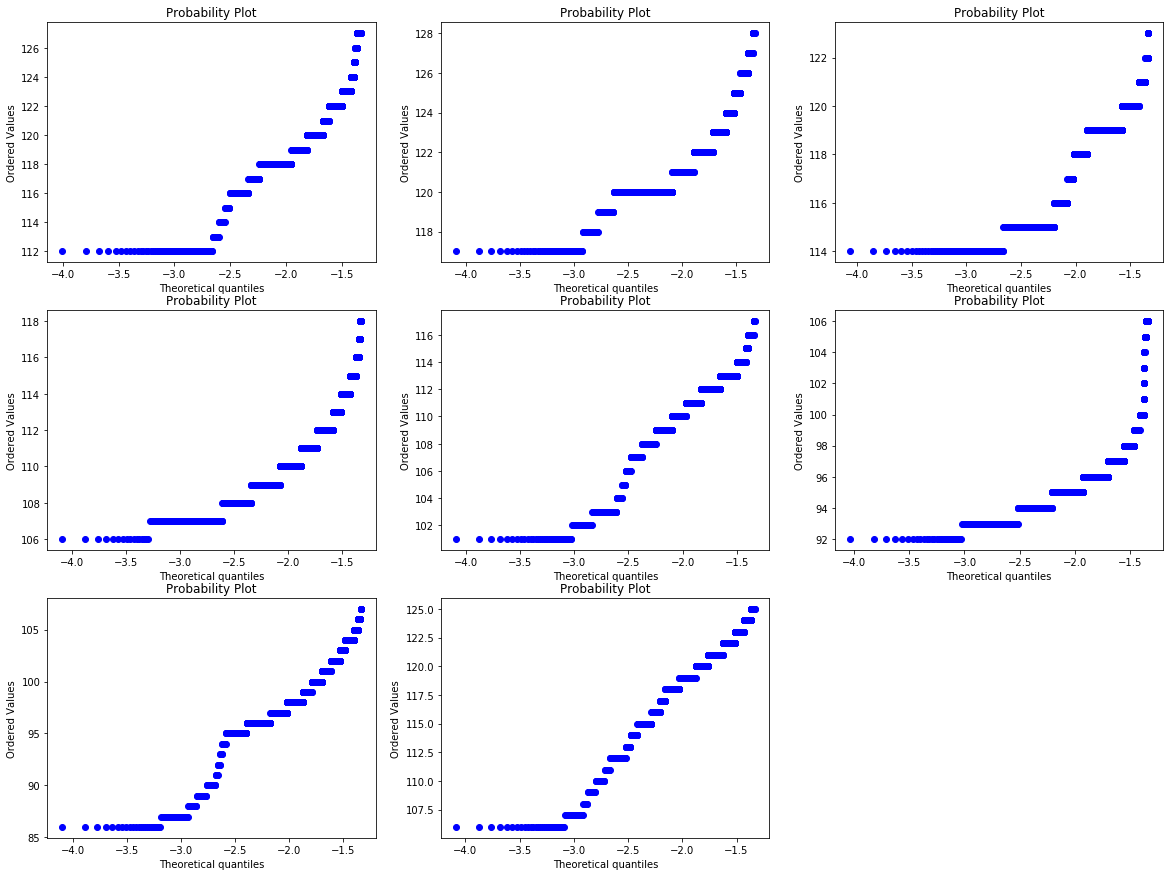

In [27]:
fig = plt.figure(figsize = (20,15))
for i in range(1,9):
    exec(f'ax{i} = fig.add_subplot(33{i})')
    stats.probplot(eval("hr_activity4_sub"+str(i)), dist = "norm", plot =pylab)

The plots indicate that for all subjects the distribution of heart rate for activity 4 (walking) deviates heavily from normal.

### Shapiro-Wilk tests

We can confirm this by performing the Shapiro-Wilk test for each subject. We will use the same hypothesis test and criterion for each test and will remove NaN values as the test will not work otherwise.

$H_0$: Distribution of heart rate does not deviate from normal.

$H_1$: Distribution of heart rate does deviate from normal.

We use $\alpha$ = 0.05 as our criterion.

In [28]:
for i in range(1,9):
    exec(f'a4_clean_heart_rate{i}= hr_activity4_sub{i}[~np.isnan(hr_activity4_sub{i})]')
    exec(f'a4_shapiro{i}=stats.shapiro(a4_clean_heart_rate{i})')
    print(['Results of test: w and p for activity 4 for subject10'+str(i) ,eval("a4_shapiro"+str(i))])

['Results of test: w and p for activity 4 for subject101', (0.963202953338623, 2.42180777530281e-22)]
['Results of test: w and p for activity 4 for subject102', (0.963025689125061, 6.4373341722668384e-27)]
['Results of test: w and p for activity 4 for subject103', (0.90372234582901, 5.190404467184651e-38)]
['Results of test: w and p for activity 4 for subject104', (0.9775328040122986, 4.501417131008059e-21)]
['Results of test: w and p for activity 4 for subject105', (0.9006144404411316, 6.35145535447545e-40)]
['Results of test: w and p for activity 4 for subject106', (0.8705103993415833, 2.063117716040785e-40)]
['Results of test: w and p for activity 4 for subject107', (0.928353488445282, 4.882031296746691e-36)]
['Results of test: w and p for activity 4 for subject108', (0.8705224394798279, 9.949219096706201e-44)]


Our p values are very small and so less than the usual criterion of $\alpha$ = 0.05. Hence we reject our null hypothesis for each subject in favour of the alternative hypothesis.

We conduct the Shapiro-Wilk tests again for running and lying.

In [29]:
for i in subjects:
    exec(f'a5_clean_heart_rate{i}= hr_activity5_sub{i}[~np.isnan(hr_activity5_sub{i})]')
    exec(f'a5_shapiro{i}=stats.shapiro(a5_clean_heart_rate{i})')
    print(['Results of test: w and p for activity 5 for subject10'+str(i) ,eval("a5_shapiro"+str(i))])

['Results of test: w and p for activity 5 for subject101', (0.7913857698440552, 1.961817850054744e-44)]
['Results of test: w and p for activity 5 for subject102', (0.8927716016769409, 9.029310598629659e-24)]
['Results of test: w and p for activity 5 for subject105', (0.7614722847938538, 0.0)]
['Results of test: w and p for activity 5 for subject106', (0.7176023721694946, 0.0)]
['Results of test: w and p for activity 5 for subject107', (0.858546257019043, 6.014428910384084e-17)]
['Results of test: w and p for activity 5 for subject108', (0.8596542477607727, 7.580870515983437e-34)]


We can see that the distributions deviate from normal.

In [30]:
for i in range(1,9):
    exec(f'a1_clean_heart_rate{i}= hr_activity1_sub{i}[~np.isnan(hr_activity1_sub{i})]')
    exec(f'a1_shapiro{i}=stats.shapiro(a1_clean_heart_rate{i})')
    print(['Results of test: w and p for activity 1 for subject10'+str(i) ,eval("a1_shapiro"+str(i))])

['Results of test: w and p for activity 1 for subject101', (0.8883888721466064, 4.0278166357381806e-39)]
['Results of test: w and p for activity 1 for subject102', (0.8073059320449829, 7.006492321624085e-45)]
['Results of test: w and p for activity 1 for subject103', (0.8020638227462769, 2.942726775082116e-44)]
['Results of test: w and p for activity 1 for subject104', (0.8137967586517334, 4.624284932271896e-44)]
['Results of test: w and p for activity 1 for subject105', (0.7434638738632202, 0.0)]
['Results of test: w and p for activity 1 for subject106', (0.7297447919845581, 0.0)]
['Results of test: w and p for activity 1 for subject107', (0.8198995590209961, 2.802596928649634e-45)]
['Results of test: w and p for activity 1 for subject108', (0.7294957637786865, 0.0)]


### Mann-Whitney tests

Now that we know that all of our distributions of heart rate for our chosen activities deviate from normal, we can conduct statistical tests. Of course we can't use the usual normal or t-tests and so opt for another one.

First we will test running against walking. Each subject will have their own pace for walking and running and so we might expect some dependence between results. Unfortunately we can't use the Wilcoxon signed rank test as our arrays have different lengths which is not permitted. Hence we use the Mann-Whitney-U-test. Subject 3 and 4 have to be left out of some of the tests as they do not participate in running, meaning we're missing some results.

We choose our criterion to be the same again, $\alpha$ = 0.05.

In [31]:
for i in subjects: #We use our previously cleaned heart rates for each activity.
    hr_activity4_5 = stats.mannwhitneyu(eval("a4_clean_heart_rate"+str(i)),eval("a5_clean_heart_rate"+str(i)),alternative='less')
    print('walking-running for subject10{}:'.format(i), hr_activity4_5)

walking-running for subject101: MannwhitneyuResult(statistic=21360.0, pvalue=0.0)
walking-running for subject102: MannwhitneyuResult(statistic=759986.5, pvalue=3.491827702184976e-69)
walking-running for subject105: MannwhitneyuResult(statistic=315556.5, pvalue=0.0)
walking-running for subject106: MannwhitneyuResult(statistic=0.0, pvalue=0.0)
walking-running for subject107: MannwhitneyuResult(statistic=337934.0, pvalue=3.7893410324462384e-26)
walking-running for subject108: MannwhitneyuResult(statistic=350894.5, pvalue=0.0)


We use the parameter alternative = "less" so that the p-value's correspond to our alternative hypotheses. Our p-value's are very small and four out of six are 0 meaning that we can conclude that heart rates when walking are less than running for every subject that participated.

In [32]:
for i in subjects:
    hr_activity1_5 = stats.mannwhitneyu(eval("a1_clean_heart_rate"+str(i)),eval("a5_clean_heart_rate"+str(i)),alternative='less')
    print('lying-running for subject10{}:'.format(i), hr_activity1_5)

lying-running for subject101: MannwhitneyuResult(statistic=0.0, pvalue=0.0)
lying-running for subject102: MannwhitneyuResult(statistic=0.0, pvalue=0.0)
lying-running for subject105: MannwhitneyuResult(statistic=0.0, pvalue=0.0)
lying-running for subject106: MannwhitneyuResult(statistic=0.0, pvalue=0.0)
lying-running for subject107: MannwhitneyuResult(statistic=11451.5, pvalue=7.873825137122612e-185)
lying-running for subject108: MannwhitneyuResult(statistic=0.0, pvalue=0.0)


Again our p-value's are very small meaning that we can conclude that heart rates when lying are less than running for every subject that participated. We now do our final test, lying versus walking. We can use all of our applicable subjects again.

In [33]:
for i in range(1,9):
    hr_activity1_4 = stats.mannwhitneyu(eval("a1_clean_heart_rate"+str(i)),eval("a4_clean_heart_rate"+str(i)),alternative='less')
    print('lying-walking for subject10{}:'.format(i), hr_activity1_4)

lying-walking for subject101: MannwhitneyuResult(statistic=0.0, pvalue=0.0)
lying-walking for subject102: MannwhitneyuResult(statistic=0.0, pvalue=0.0)
lying-walking for subject103: MannwhitneyuResult(statistic=0.0, pvalue=0.0)
lying-walking for subject104: MannwhitneyuResult(statistic=255724.0, pvalue=0.0)
lying-walking for subject105: MannwhitneyuResult(statistic=0.0, pvalue=0.0)
lying-walking for subject106: MannwhitneyuResult(statistic=467992.0, pvalue=0.0)
lying-walking for subject107: MannwhitneyuResult(statistic=3200.0, pvalue=0.0)
lying-walking for subject108: MannwhitneyuResult(statistic=0.0, pvalue=0.0)


Once again as we would expect the difference in heart rate for subjects when lying compared to walking is very statistically significant.

Now that we know that heart rate is a good indicator of the activity being performed, we aim to use machine learning methods (mainly clustering) to help identify what activity is being performed from results of heart rate over time. If we can do this successfully, we will also be able to see how long the activity is carried out for.

# Clustering

We are now going to investigate the clustering method that I hinted to previously on our time versus heart rate scatters. We aim to be able to cluster the data, therefore predicting what activity is taking place at a certain time based on the subjects current heart rate. 

First we will import the modules required for clustering.

In [34]:
from sklearn import cluster
from sklearn.metrics.cluster import silhouette_score 
from sklearn.metrics.cluster import adjusted_rand_score

We are first going to work with subject109 as they perform the least activities meaning the number of clusters that needs to be produced is much lower than the other subjects. Plots will be much less cluttered for this subject than others.

## K-means

Initially, the number of clusters we input as a parameter when fitting the model (K) are used as initial centroids. The algorithm then forms K clusters by assigning each point to its nearest centroid. Centroids are then recalculated and then this process is repeated until clusters are formed. Using init = "random" means that the K initial centroids are chosen at random from data.

One of the big disadvantages of the K-means implementation is that you must specify the number of clusters in advance. However, in the context of our data, this is not much of a hinderence at all. This is because we know the number of activities that have been performed by the subjects already. Although, if the method did not need to take the number of clusters, this would make our model more useful in more general applications where the number of activities performed is not known already. We will expand upon this later when we do Agglomerative clustering.

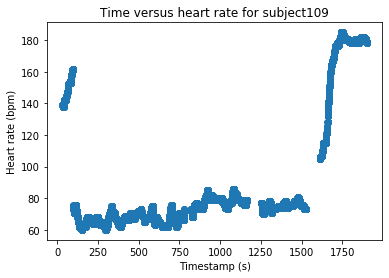

In [35]:
plt.scatter(timestamp9, heart_rate9)
plt.title("Time versus heart rate for subject109")
plt.xlabel("Timestamp (s)")
plt.ylabel("Heart rate (bpm)")
plt.show()

We can clearly see above that there are obvious clusters in the data - most noticeably at the start and the end of the testing.

We now aim to create a function that will cluster for us with the help of sklearn's clustering module. This function takes a dataframe and the number of clusters (number of activities performed by the subject). We then use our previously imported cluster module to produce clustering for us. A new DataFrame is then created that is a copy of the original but with an extra "cluster" column that contains the predicted cluster for each row. 

The activity variable then stores the first activityid that corresponds to each cluster value. This allows us to directly predict the activity based on the clustering. The scatter is replotted but with clusters coloured and the predicted activities are shown in the legend.

It is important to note that our original DataFrames do not work with the clustering as heart_rate has many NaN values which are not accounted for during clustering. To solve this we drop every row with a NaN value and assign to a new DataFrame and use this one in clustering instead.

In [36]:
def clusters(df, num_clusters):
    clf = cluster.KMeans(init = "random", n_clusters = num_clusters)
    clf.fit(df[["timestamp", "heart_rate"]])
    df["cluster"] = clf.predict(df[["timestamp", "heart_rate"]])
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        activity = df.loc[df['cluster'] == n, 'activityid'].iloc[0]
        plt.scatter(clustered_df['timestamp'], clustered_df['heart_rate'], label = 'activity id: '+str(activity))
    plt.legend()
    plt.title("Time versus heart rate with K-Means clustering")
    plt.xlabel("Timestamp")
    plt.ylabel("Heart rate (bpm)")
    plt.show()

In [37]:
sub9nonan = sub9.dropna()

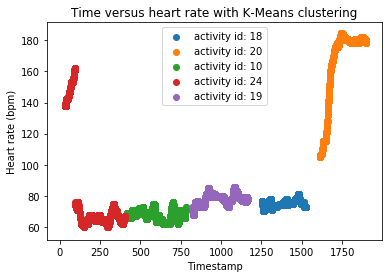

In [38]:
clusters(sub9nonan, 5)

We can directly see if these clusters are correct by looking at the sub9 DataFrame.

In [39]:
sub9[sub9["timestamp"] > 30.22].head(1)

,timestamp,activityid,heart_rate,hand_temp,hand16_1,hand16_2,hand16_3,handgyro1,handgyro2,handgyro3,...,ankle_temp,ankle16_1,ankle16_2,ankle16_3,anklegyro1,anklegyro2,anklegyro3,anklemagnet1,anklemagnet2,anklemagnet3
1573,31.2,24,NaN,24.875,-9.02648,3.43661,1.54825,0.555154,-0.151351,0.056916,...,31.3125,6.10403,0.984611,-4.55185,-0.101032,-0.057742,-0.248516,-41.8305,-16.0762,5.25108


We can see that our clustering has correctly predicted that subject109 is undertaking activity24 (rope jumping) at the start of data collection.

In [40]:
sub9[sub9["timestamp"] > 100.03].head(1)

,timestamp,activityid,heart_rate,hand_temp,hand16_1,hand16_2,hand16_3,handgyro1,handgyro2,handgyro3,...,ankle_temp,ankle16_1,ankle16_2,ankle16_3,anklegyro1,anklegyro2,anklegyro3,anklemagnet1,anklemagnet2,anklemagnet3
12976,100.03,10,NaN,30.8125,-9.04982,3.21329,2.0105,-0.063332,0.047518,-0.037493,...,31.625,9.56979,1.05959,-2.43294,0.014325,0.005658,0.04227,-53.0006,4.82781,50.5738


However, at ~100s into data collection, the activity changes to activity10 (computer work) but our function is still clustering with the previous activity. Even though the heart rates are very different, the clustering has failed for this section.

In [41]:
sub9[sub9["timestamp"] > 500.07].head(1)

,timestamp,activityid,heart_rate,hand_temp,hand16_1,hand16_2,hand16_3,handgyro1,handgyro2,handgyro3,...,ankle_temp,ankle16_1,ankle16_2,ankle16_3,anklegyro1,anklegyro2,anklegyro3,anklemagnet1,anklemagnet2,anklemagnet3
52981,500.08,10,72.0,32.5,-0.188822,2.10992,9.42107,0.006165,0.004784,0.005486,...,33.0,8.88905,-4.52395,-1.63348,0.045313,-0.034061,0.005743,-52.7592,-1.40293,37.3915


Our clustering changes to activity10 at around 500s even though this activity was being performed from around 100s.

In [42]:
sub9[sub9["timestamp"] > 1000.03].head(1)

,timestamp,activityid,heart_rate,hand_temp,hand16_1,hand16_2,hand16_3,handgyro1,handgyro2,handgyro3,...,ankle_temp,ankle16_1,ankle16_2,ankle16_3,anklegyro1,anklegyro2,anklegyro3,anklemagnet1,anklemagnet2,anklemagnet3
102977,1000.04,19,80.0,33.25,2.46984,10.4883,-1.69023,-0.222544,0.229362,0.346495,...,33.9375,9.61742,0.90427,-2.04559,-0.169798,0.076281,-0.184421,-35.0201,-10.1557,32.4999


In [43]:
sub9[sub9["timestamp"] > 1252.92].head(1)

,timestamp,activityid,heart_rate,hand_temp,hand16_1,hand16_2,hand16_3,handgyro1,handgyro2,handgyro3,...,ankle_temp,ankle16_1,ankle16_2,ankle16_3,anklegyro1,anklegyro2,anklegyro3,anklemagnet1,anklemagnet2,anklemagnet3
128266,1252.93,18,77.0,33.0625,2.48499,8.19289,4.66816,-0.021521,-0.019007,0.069533,...,34.1875,9.58598,1.20697,-1.89343,-0.0094,0.011916,0.017846,-42.5676,12.9028,40.2474


In [44]:
sub9[sub9["timestamp"] > 1612.48].head(1)

,timestamp,activityid,heart_rate,hand_temp,hand16_1,hand16_2,hand16_3,handgyro1,handgyro2,handgyro3,...,ankle_temp,ankle16_1,ankle16_2,ankle16_3,anklegyro1,anklegyro2,anklegyro3,anklemagnet1,anklemagnet2,anklemagnet3
164222,1612.49,20,106.0,25.125,-0.344649,9.76747,0.078954,0.077527,-0.006135,0.0186,...,31.4375,9.6321,-0.078011,-2.65678,-0.031197,-0.056391,0.016361,-46.1997,-5.4463,-0.308075


This activity has also been predicted correctly.

Overall, out of the 5 activities performed by subject109, our clustering method has correctly predicted 4/5 of the activities being carried out by the subject based entirely on the relationship between time and heart rate. 

We now calculate a silhouette score for our clustering attempt. This is a method that measures how similar an object is to its own cluster relative to other clusters. Scores range from -1 to +1, with these scores being averaged for every cluster to produce an overall score. Each score for a given data point $i$ is calculated with the formula:



$$s(i) = \frac{b(i) - a(i)}{max\{a(i), b(i)\}}$$

Where $a$ is the distance to the nearest other point within the same cluster (intra-cluster distance) and $b$ is the distance to the nearest other point not in the same cluster (inter-cluster distance).

In [45]:
clf = cluster.KMeans(init = "random", n_clusters = 5)
clf.fit(sub9nonan[["timestamp", "heart_rate"]])
prediction9 = clf.predict(sub9nonan[["timestamp", "heart_rate"]])
s=silhouette_score(sub9nonan[["timestamp", "heart_rate"]],prediction9) # calculate silhouette score
print("Silhouette score for subject109 K-means clustering: {}".format(s))

Silhouette score for subject109 K-means clustering: 0.6284966102809623


We now aim to compute the adjusted rand score in addition to our silhouette score. This is another measure of similarity between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

Raw rand index:

Given a set of ${\displaystyle n}$ elements ${\displaystyle S=\{o_{1},\ldots ,o_{n}\}}$ and two partitions of ${\displaystyle S}$ to compare, ${\displaystyle X=\{X_{1},\ldots ,X_{r}\}}$ a partition of $S$ into $r$ subsets, and ${\displaystyle Y=\{Y_{1},\ldots ,Y_{s}\}}$, a partition of $S$ into $s$ subsets, define the following:

$a$, the number of pairs of elements in $S$ that are in the same subset in $X$ and in the same subset in $Y$

$b$, the number of pairs of elements in $S$ that are in different subsets in $X$ and in different subsets in $Y$

$c$, the number of pairs of elements in $S$ that are in the same subset in $X$ and in different subsets in $Y$

$d$, the number of pairs of elements in $S$ that are in different subsets in $X$ and in the same subset in $Y$


The Rand index, $R$, is:

$$R={\frac {a+b}{a+b+c+d}}$$

This raw rand index is then adjusted for chance using the formula:

$$ARI = \frac{(RI - ExpectedRI)}{(max(RI) - ExpectedRI)}$$

In [46]:
#15017 rows, 5 clusters = 3003.4 cluster values each. 15017 not divisible by 5 so add on two extra cluster values of 4. 
#Provides some inaccuracy but shouldn't affect the score too much.
perfectcluster = [0]*3003 + [1]*3003 + [2]*3003 + [3]*3003 + [4]*3005
a=adjusted_rand_score(perfectcluster,clf.predict(sub9nonan[["timestamp", "heart_rate"]])) # calculate adjusted rand score
print("Adjusted rand score for subject 109 K-means clustering: {}".format(a))

Adjusted rand score for subject 109 K-means clustering: 0.6693397617875095


Hence we can see that our clustering for subject109 is acceptable. Originally I did the same for subject103 to check consistency of clustering over mutliple subjects but I will include this in the appendix as I believe to not be as relevant as other areas of interest for this notebook. 

I am now going to see how well our clustering works with a different relationship. Previously we have been using time and heart rate as our activity predictors but now I am going to try the clustering on a plot of timestamp versus mean acceleration that I calculated earlier.
We will compute our rand and silhoutte scores to see how they compare to the previous clustering to see which is a better match for our data.

Text(0, 0.5, 'Mean acceleration ($ms^{-2}$)')

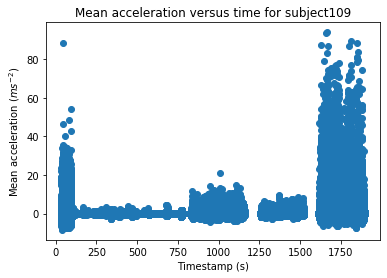

In [47]:
plt.scatter(sub9.timestamp, meanacceleration9)
plt.title("Mean acceleration versus time for subject109")
plt.xlabel("Timestamp (s)")
plt.ylabel("Mean acceleration ($ms^{-2}$)")

We first add a new column to the sub9 DataFrame, mean acceleration. Then we modify our clusters function to take acceleration as a parameter instead of heart rate.

In [48]:
sub9nonan["acceleration"] = meanacceleration9

In [49]:
def accelerationclusters(df, num_clusters):
    clf = cluster.KMeans(init = "random", n_clusters = num_clusters)
    clf.fit(df[["timestamp", "acceleration"]])
    df["cluster"] = clf.predict(df[["timestamp", "acceleration"]])
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        activity = df.loc[df['cluster'] == n, 'activityid'].iloc[0]
        plt.scatter(clustered_df['timestamp'], clustered_df['acceleration'], label = 'activity id: '+str(activity))
    plt.legend()
    plt.title("Time versus acceleration with K-Means clustering")
    plt.xlabel("Timestamp (s)")
    plt.ylabel("Mean acceleration ($ms^{-2}$)")
    plt.show()

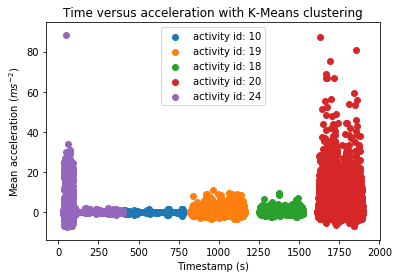

In [50]:
accelerationclusters(sub9nonan, 5)

In [51]:
acceleration_prediction9 = clf.predict(sub9nonan[["timestamp", "acceleration"]])
s=silhouette_score(sub9nonan[["timestamp", "acceleration"]],acceleration_prediction9) # calculate silhouette score
print("Silhouette score for subject109 K-means clustering: {}".format(s))

Silhouette score for subject109 K-means clustering: 0.6307977386823186


In [52]:
#15017 rows, 5 clusters = 3003.4 cluster values each. 15017 not divisible by 5 so add on two extra cluster values of 4. 
#Provides some inaccuracy but shouldn't affect the score too much.
perfectcluster = [0]*3003 + [1]*3003 + [2]*3003 + [3]*3003 + [4]*3005
a=adjusted_rand_score(perfectcluster,clf.predict(sub9nonan[["timestamp", "acceleration"]])) # calculate adjusted rand score
print("Adjusted rand score for subject 109 K-means clustering: {}".format(a))

Adjusted rand score for subject 109 K-means clustering: 0.6719068467356092


The adjusted rand scores for clustering on a plot of time versus heart rate and clustering on a plot of time versus acceleration for subject109 are around the same. However, the silhoutte score for clustering with heart rate is over 0.05 higher than the score for clustering with acceleration. 

Hence we can say that clustering over time versus heart rate is more suitable than time versus acceleration for subject109. This may not of course be true for the other subjects but we will use it as indication to proceed with using heart rate as we have been doing thoughout this notebook over other indicator variables.

To avoid dependence on time-series data, I also tried to see how well clustering takes place over a plot of heart rate versus mean acceleration for subject109. As time is not an indicator of the activity being performed, I believe this new plot might be more useful as acceleration and heart rate are both good indicators of activity in their own right. However, this was not the case and so I opted not to include the result in the notebook and instead it is in the appendix.

## Agglomerative clustering

Unlike K-means, agglomerative clustering takes n clusters as the n data points, finding the clostest pair of clusters initially with a distance threshold. It then merges these two clusters and finds the next closest cluster and so on. One of the biggest advantages over K-means is that agglomerative clustering does not need the number of clusters to be specified in advance. Considering we know the number of activities already though, the best results would be achieved when we specify the number of clusters to be equal to the number of activities we know the subject performs. However, in the context of our overall aims, Agglomerative clustering may be preferred to K-means as our software/hardware will not know the number of activities performed by the individual using it.

The largest downside to this method is that its runtime is in $O(n^2log(n))$ whereas K-means is in $O(n^2)$ which can mean that the algorithm takes much longer than K-means for a large number of activities. Hence for our software/hardware K-means may be preferable as subjects will tend to perform a wide range of activities throughout the day.

We modify our clusters function slightly in order to use the agglomerative clustering method rather than K-means.

In [53]:
from sklearn.cluster import AgglomerativeClustering as Agg
def agg_clusters(df, num_clusters):
    agg_clf = Agg(linkage = "ward", n_clusters = num_clusters)
    agg_clf.fit(df[["timestamp", "heart_rate"]])
    df["cluster"] = agg_clf.fit_predict(df[["timestamp", "heart_rate"]])
    s = silhouette_score(df[["timestamp", "heart_rate"]],df["cluster"])
    print("Silhouette score for clustering: {}".format(s))
    perfectcluster = [0]*3003 + [1]*3003 + [2]*3003 + [3]*3003 + [4]*3005
    a=adjusted_rand_score(perfectcluster,agg_clf.fit_predict(df[["timestamp", "heart_rate"]])) # calculate adjusted rand score
    print("Adjusted rand score for clustering: {}".format(a))
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        activity = df.loc[df['cluster'] == n, 'activityid'].iloc[0]
        plt.scatter(clustered_df['timestamp'], clustered_df['heart_rate'], label = 'activity id: '+str(activity))
    plt.legend()
    plt.title("Time versus heart rate using agglomerative clustering")
    plt.xlabel("Timestamp")
    plt.ylabel("Heart rate (bpm)")
    plt.show()

Silhouette score for clustering: 0.590816564762608
Adjusted rand score for clustering: 0.60162774998245


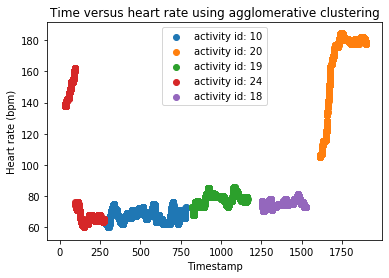

In [54]:
agg_clusters(sub9nonan, 5)

This gives pretty much exactly the same results as K-means clustering, with the small differences in the overlap over clusters.

We are now going to try the computation using the linkages "complete" and "average" aswell as "ward". 

The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion:

$-$Ward minimizes the variance of the clusters being merged.

$-$Average uses the average of the distances of each observation of the two sets.

$-$Complete or maximum linkage uses the maximum distances between all observations of the two sets.

We alter our previous function once again to loop over the different linkages and calculate the scores for each. We will compute the silhouette scores and adjusted rand indexes for each implementation to see which one provides the best clustering results.

In [55]:
def agg_links_clusters(df, num_clusters):
    links = ["ward", "complete", "average"]
    colours = ["b", "r", "g", "m", "y"]
    for linkage in links:
        agg_clf = Agg(linkage = linkage, n_clusters = num_clusters)
        agg_clf.fit(df[["timestamp", "heart_rate"]])
        df["cluster"] = agg_clf.fit_predict(df[["timestamp", "heart_rate"]])
        s = silhouette_score(df[["timestamp", "heart_rate"]],df["cluster"])
        print("Silhouette score for {} clustering: {}".format(linkage, s))
        perfectcluster = [0]*3003 + [1]*3003 + [2]*3003 + [3]*3003 + [4]*3005
        a=adjusted_rand_score(perfectcluster,agg_clf.fit_predict(df[["timestamp", "heart_rate"]])) # calculate adjusted rand score
        print("Adjusted rand score for {} clustering: {}".format(linkage, a))
        
        for n in range(num_clusters):
            clustered_df = df[df['cluster'] == n]
            activity = df.loc[df['cluster'] == n, 'activityid'].iloc[0]
            plt.scatter(clustered_df['timestamp'], clustered_df['heart_rate'], label = 'activity id: '+str(activity), c = colours[n-1])
        plt.legend()
        plt.title(linkage)
        plt.xlabel("Timestamp (s)")
        plt.ylabel("Heart rate (bpm)")
        plt.show()

Silhouette score for ward clustering: 0.590816564762608
Adjusted rand score for ward clustering: 0.60162774998245


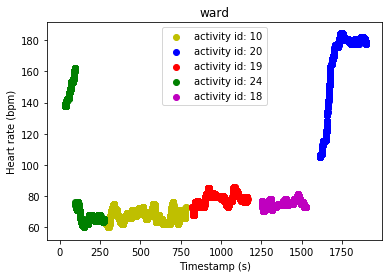

Silhouette score for complete clustering: 0.6263688962660331
Adjusted rand score for complete clustering: 0.6312016692895671


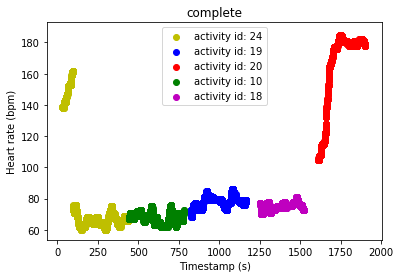

Silhouette score for average clustering: 0.5970998933796673
Adjusted rand score for average clustering: 0.5735528117704599


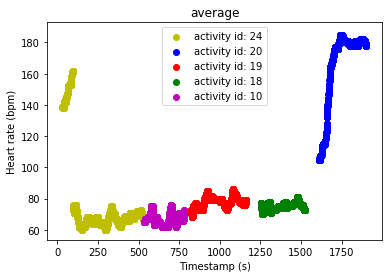

In [56]:
agg_links_clusters(sub9nonan, 5)

From the plots above it seems that Agglomerative clustering performs best when the linkage used is "complete". 

Overall, we can say that clustering activity performed by subject109 achieves best results when K-means clustering is used over agglomerative clustering and when clustering is done over a plot of time versus heart rate and not time versus acceleration. However, agglomerative clustering with the linkage "complete" is also a good model. 

### Agglomerative clustering but not specifying number of clusters

Here is the implementation of agglomerative clustering whereby the number of clusters does not need to be specified. From trial and error, for subject109 the best distance threshold has a value of 4300. This is the linkage distance threshold above which, clusters will not be merged. This means that our model can detect the number of activities and the amount of exercise performed without knowing them previously. 

In [57]:
def agg_no_clusters(df):
    agg_clf = Agg(linkage = "ward", n_clusters = None, distance_threshold = 4300)
    agg_clf.fit(df[["timestamp", "heart_rate"]])
    df["cluster"] = agg_clf.fit_predict(df[["timestamp", "heart_rate"]])
    unique_clusters = [] 
    s = silhouette_score(df[["timestamp", "heart_rate"]],df["cluster"])
    print("Silhouette score for clustering: {}".format(s))
    perfectcluster = [0]*3003 + [1]*3003 + [2]*3003 + [3]*3003 + [4]*3005
    a=adjusted_rand_score(perfectcluster,agg_clf.fit_predict(df[["timestamp", "heart_rate"]])) # calculate adjusted rand score
    print("Adjusted rand score for clustering: {}".format(a))
    for x in df["cluster"]: 
        if x not in unique_clusters: 
            unique_clusters.append(x)
    for n in unique_clusters:
        clustered_df = df[df['cluster'] == n]
        activity = df.loc[df['cluster'] == n, 'activityid'].iloc[0]
        plt.scatter(clustered_df['timestamp'], clustered_df['heart_rate'], label = 'activity id: '+str(activity))
    plt.legend(loc = "upper center")
    plt.title("Agglomerative clustering with no specified number of clusters")
    plt.xlabel("Timestamp (s)")
    plt.ylabel("Heart rate (bpm)")
    plt.show()

Silhouette score for clustering: 0.5356755177369217
Adjusted rand score for clustering: 0.4822189696075465


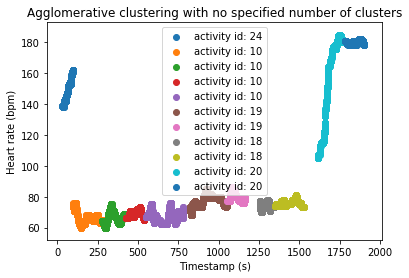

In [58]:
agg_no_clusters(sub9nonan) #Using the ward linkage as it provides the best results.

Despite our silhoutte and rand scores being lower than they were previously, this method corrects the earlier problem of our models mislabeling activities and so this implementation gives us the most accurate model so far. However, in reality our software/hardware will not know the number of activities and so this method will incorrectly inflate the number of suspected activities that have taken place. It is also underwhelming in the sense that multiple clusters are assigned to the same activity. 

Included in the appendix is an expanded model of our K-means clustering but for the original data including the activityID = 0 values. The original function has been modified so that clustering works on this data while also telling you how many activityID = 0 values there are contained in each cluster which gives an idea of the interference that these values have on the clusters.

# Conclusion

In conclusion, we have carried out some good exploratory data analysis and hence identified that heart rate is the best indicator regarding the amount and type of physical activity carried out. We then explored this assumption further in our hypothesis testing section to see the extent to which this was true from a statistical point of view. Our results gave us good evidence that this assumption was correct and so this allowed us to proceed in training clustering models that provided predictions.

We now have viable insights from the data that can be used to develop various software/hardware that can be used to do the same for individuals in their daily life. Let's say that this can be in the form a piece of hardware that's similar to a fitbit and we'll assume it stores general data similar to the type we have recieved. In particular, acceleration and heart rate are the types of data that should be taken with priority as these are the two best indicators. 

This hardware can use our clustering models to determine statistics surrounding the type of activities the individual performs and how long they have performed them for. Based on user inputs such as weight loss plans, the hardware may be able to recommend activities that it believes will be the most suitable for them based on the effect that the activity has on heart rate. 

Throughout this project we have mostly explored heart rate as our primary indicator but we have also looked at acceleration. Even though we only performed a couple of examples of clustering using acceleration, it still seemed like it was a good enough indicator to be explored further when implementening the hardware. Ideally, we would have also performed a form of regression for heart rate (or acceleration). Training a model based on our data would allow us to predict heart rates for individuals with the hardware with more samples.

Another way we could expand on our investigations is by further using acceleration to calculate the velocity of the subjects and hence find the distance travelled by subjects during different activities. The accuracy of these calculations could also be improved by using the magnetometer and gyroscopic data in combination with acceleration using a kalman/complementary filter.

Additionally, we should note the drawbacks of the data and the subsequent effects this has on our testing. First of all, the amount of subjects included in the study is not very high and so our conclusions are not as significant as they could be with a higher sample size. Eight of the subjects are also men who are in the age range 23-31, meaning that our models are really only viable for young men, meaning our hardware is flawed when anyone but young men use it. Ideally, all subjects would also perform the same number and type of activities around the same times so that we could make better conclusions.

# Appendix

### Subject information

Along with the data, a pdf regarding general information on all of the subjects was provided. We have no way to import the data and so I am manually typing it into the notebook. It seemed that many of the relationships were not very useful and so I opted to include them at the end of the notebook instead of during the exploratory data analysis section.

In [59]:
age1 = 27
age2 = 25
age3 = 31
age4 = 24
age5 = 26
age6 = 26
age7 = 23
age8 = 32
age9 = 31

height1 = 182
height2 = 169
height3 = 187
height4 = 194
height5 = 180
height6 = 183
height7 = 173
height8 = 179
height9 = 168

weight1 = 83
weight2 = 78
weight3 = 92
weight4 = 95
weight5 = 73
weight6 = 69
weight7 = 86
weight8 = 87
weight9 = 65

maxhr1 = 193
maxhr2 = 195
maxhr3 = 189
maxhr4 = 196
maxhr5 = 194
maxhr6 = 194
maxhr7 = 197
maxhr8 = 188
maxhr9 = 189

resthr1 = 75
resthr2 = 74
resthr3 = 68
resthr4 = 58
resthr5 = 70
resthr6 = 60
resthr7 = 60
resthr8 = 66
resthr9 = 54

ages = [age1, age2, age3, age4, age5, age6, age7, age8, age9]
heights = [height1, height2, height3, height4, height5, height6, height7, height8, height9]
weights = [weight1, weight2, weight3, weight4, weight5, weight6, weight7, weight8, weight9]
maxhrs = [maxhr1, maxhr2, maxhr3,maxhr4,maxhr5,maxhr6,maxhr7,maxhr8,maxhr9]
resthrs = [resthr1, resthr2, resthr3, resthr4, resthr5, resthr6, resthr7, resthr8, resthr9]
subjects = [sub1, sub2, sub3, sub4, sub5, sub6, sub7, sub8, sub9]

Text(0.5, 0, 'Age')

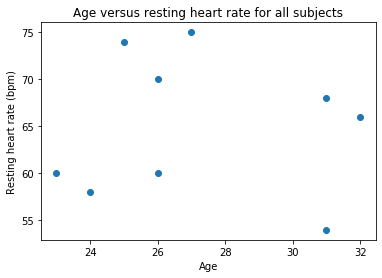

In [60]:
plt.scatter(ages, resthrs)
plt.title("Age versus resting heart rate for all subjects")
plt.ylabel("Resting heart rate (bpm)")
plt.xlabel("Age")

There is no real clear trend between the two variables.

Text(0, 0.5, 'Weight (kg)')

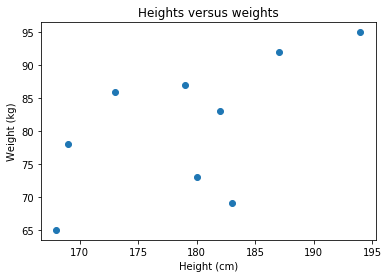

In [61]:
plt.scatter(heights, weights)
plt.title("Heights versus weights")
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")

There is some trend here. Taller subjects tend to be heavier as you would expect.

Text(0, 0.5, 'Resting heart rate (bpm)')

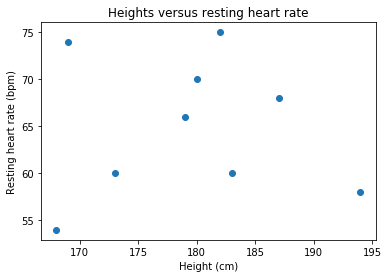

In [62]:
plt.scatter(heights, resthrs)
plt.title("Heights versus resting heart rate")
plt.xlabel("Height (cm)")
plt.ylabel("Resting heart rate (bpm)")

Text(0, 0.5, 'Resting heart rate (bpm)')

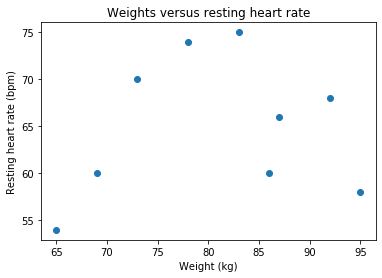

In [63]:
plt.scatter(weights, resthrs)
plt.title("Weights versus resting heart rate")
plt.xlabel("Weight (kg)")
plt.ylabel("Resting heart rate (bpm)")

### Heart rate versus temperature

In [64]:
for x in range(1,10):
    exec(f'heart_rate{x} = sub{x}.heart_rate')
    exec(f'hand_temp{x} = sub{x}.hand_temp')
    exec(f'chest_temp{x} = sub{x}.chest_temp')
    exec(f'ankle_temp{x} = sub{x}.ankle_temp')
    exec(f'avg_temp{x} = (ankle_temp{x} + chest_temp{x} + hand_temp{x})/3')
#Using exec to assign each subject's activityID column to a variable.    
#f in exec allows for the x variable in the {}.

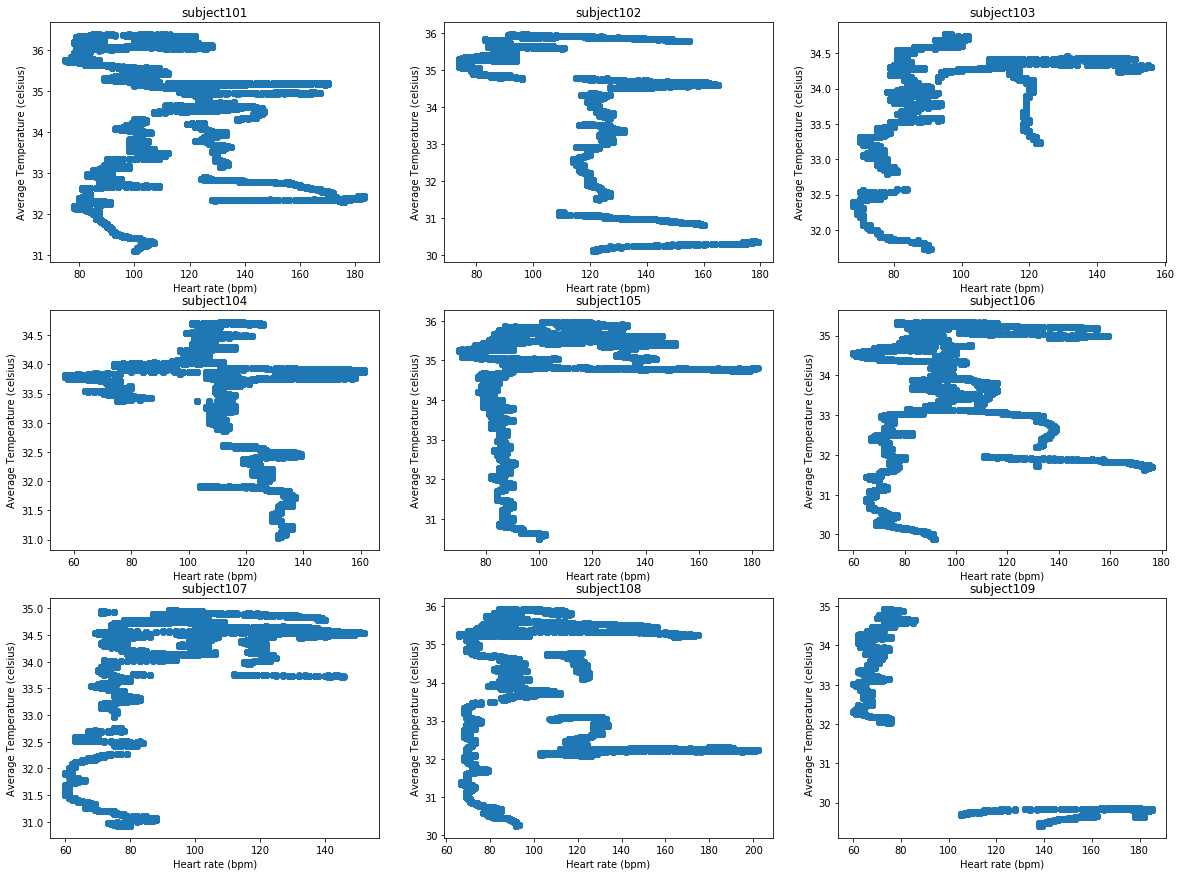

In [65]:
fig = plt.figure(figsize = (20,15))
for x in range(1,10):
    exec(f'ax{x} = fig.add_subplot(33{x})')
for i in range(1,10):
    eval("ax"+str(i)).scatter(eval("heart_rate"+str(i)), eval("avg_temp"+str(i)))
    eval("ax"+str(i)).set_xlabel("Heart rate (bpm)")
    eval("ax"+str(i)).set_ylabel("Average Temperature (celsius)")
    eval("ax"+str(i)).set_title("subject10"+str(i))

The graphs above are not as useful as I thought they were going to be. There does not seem to be any useful correlation between the two variables. Nonetheless, It seems that when intensive activity is carried out, temperature seems to rise at a higher rate than heart rate. This is most likely due to the fact that temperature does not vary much (~30-36 degrees celsius) whereas heart rate has a large variation depending on the exercise being carried out.

### Temperature versus activities

I am now aiming to plot activity versus temperature. We would expect that the subjects temperature's are highest when performing high intensity activities such as running and rope-jumping, in the same way as heart-rate.

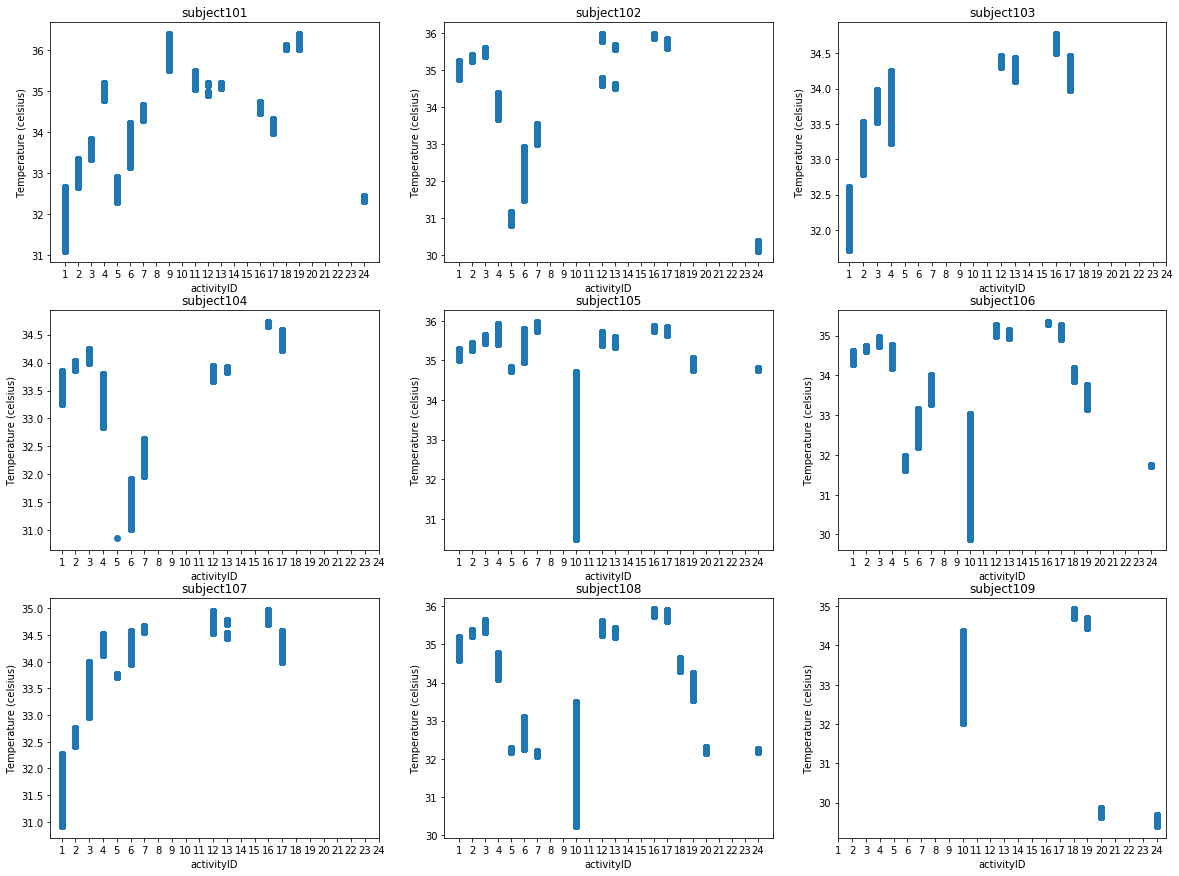

In [66]:
fig = plt.figure(figsize = (20,15))
for x in range(1,10):
    exec(f'ax{x} = fig.add_subplot(33{x})')

for i in range(1,10):
    eval("ax"+str(i)).scatter(eval("activityid"+str(i)), eval("avg_temp"+str(i)))
    eval("ax"+str(i)).set_xlabel("activityID")
    eval("ax"+str(i)).set_ylabel("Temperature (celsius)")
    eval("ax"+str(i)).set_title("subject10"+str(i))
    eval("ax"+str(i)).set_xticks(np.arange(1,25), minor=False)

These results are unfortunately very poor. The strenuity of each activity is not reflected by the subject's temperatures. 

For example, for subjects 2, 6 and 8, their temperatures reach nearly up to 36 degrees while performing low-intensity activities such as lying and sitting but have lower temperatures during high-intensity activities such as running. This is most likely again due to the fact that temperature varies over a very small range and so is not a good indicator.

Interestingly, computer work has a huge range of temperature for some subjects. This is most likely due to the fact that they switched from a very physically demanding activity to computer work quickly.

### Histograms for running

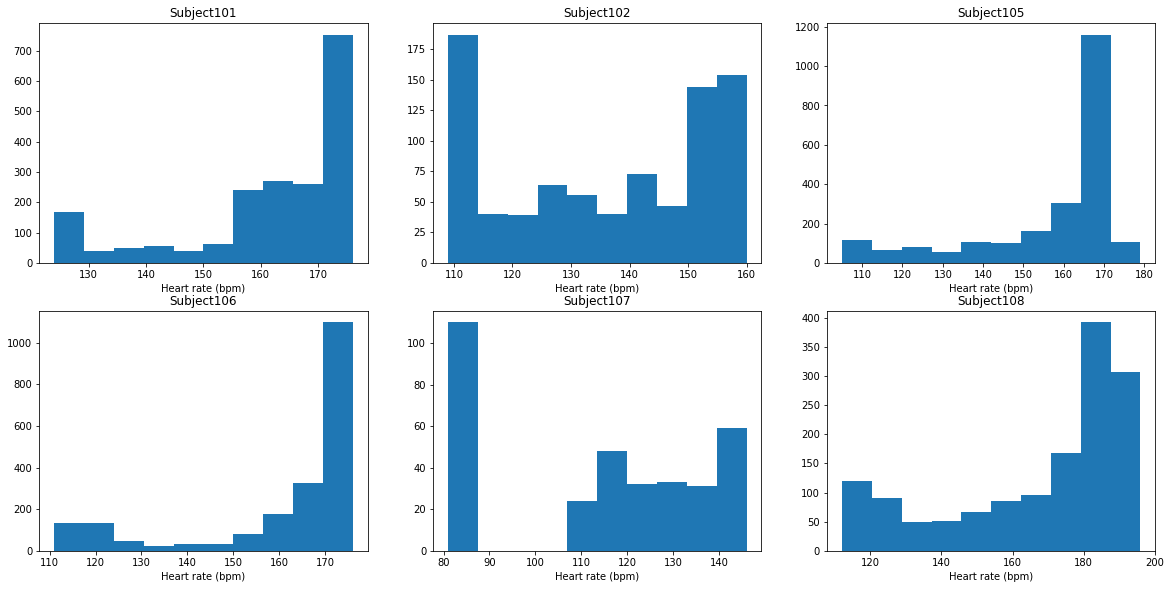

In [67]:
subjects = [1,2,5,6,7,8]
fig = plt.figure(figsize=(20,15))
for num, i in enumerate(subjects):
    exec(f'ax{num+1} = fig.add_subplot(3, 3, {num+1})')
    eval('ax'+str(num+1)).hist(eval("hr_activity5_sub"+str(i)))
    eval('ax'+str(num+1)).set_title('Frequency in Heart rate when running for subject '+str(i))
    eval("ax"+str(num+1)).set_xlabel("Heart rate (bpm)")
    eval("ax"+str(num+1)).set_title("Subject10"+str(i))

### Histograms for lying

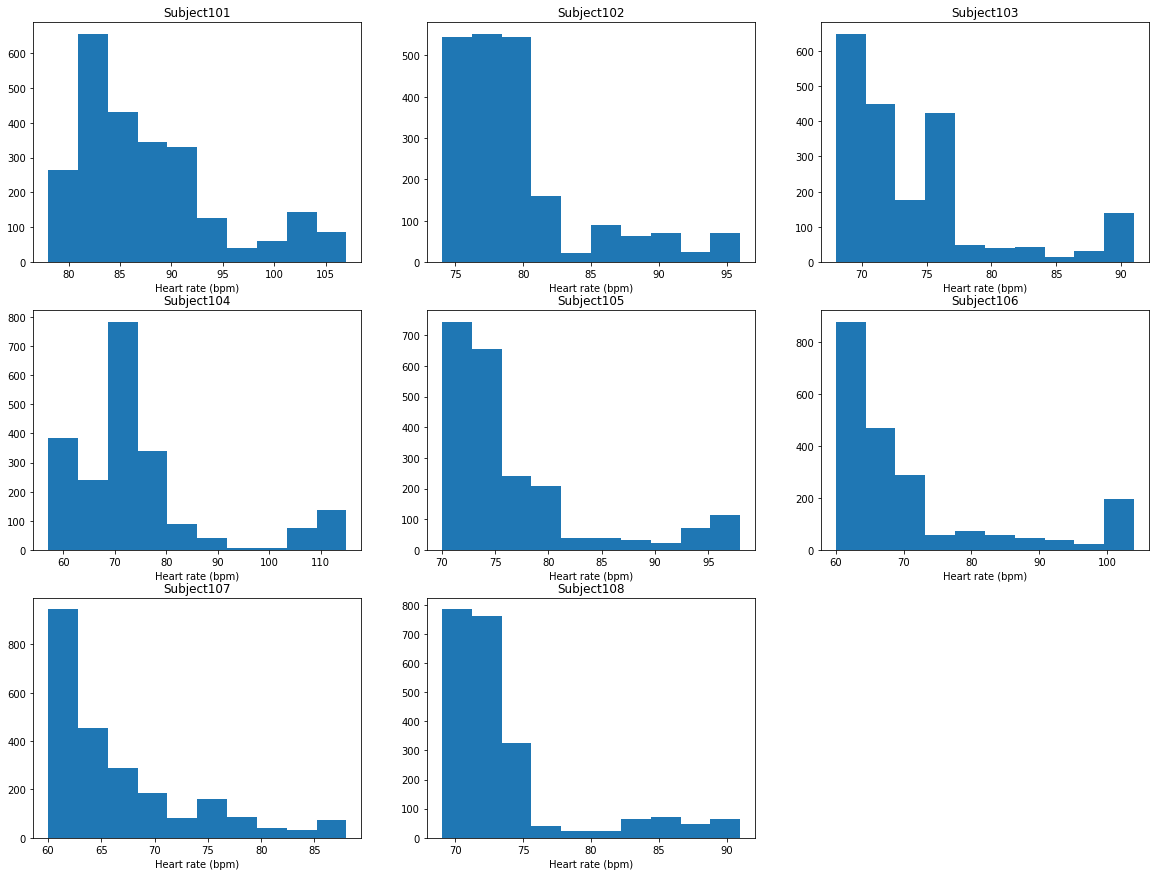

In [68]:
fig = plt.figure(figsize = (20,15))
for i in range(1,9):
    exec(f'ax{i} = fig.add_subplot(33{i})')
    eval("ax"+str(i)).hist(eval("hr_activity1_sub"+str(i)))
    eval("ax"+str(i)).set_xlabel("Heart rate (bpm)")
    eval("ax"+str(i)).set_title("Subject10"+str(i))

Like activity 4 (walking), none of the heart rates across lying or running are anywhere close to being normally distributed.

### Heart rate against time for activity 12 (ascending stairs)

In [69]:
for i in range(1,9):
    exec(f'sub{i}_activity12 = sub{i}[sub{i}.activityid == 12]')
    exec(f'hr_activity12_sub{i} = sub{i}_activity12["heart_rate"]')
    exec(f'time_activity12_sub{i} = sub{i}_activity12["timestamp"]')   
    exec(f'time_activity12_sub{i} = time_activity12_sub{i} - time_activity12_sub{i}.iloc[0]')

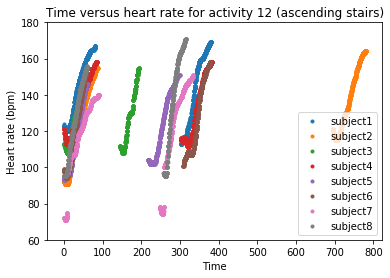

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(1,9):
    ax.scatter(eval("time_activity12_sub"+str(i)), eval("hr_activity12_sub"+str(i)), label = "subject"+str(i), marker = ".")
    ax.set_ylim(60,180)
    ax.set_ylabel("Heart rate (bpm)")
    ax.set_xlabel("Time")
    ax.set_title("Time versus heart rate for activity 12 (ascending stairs)")
    ax.legend()

### Clustering with original data

Additionally, clustering has worked well over heart rate and acceleration and so if we were to have data in the future with one of those attributes missing then we can still create a good model of predicting the activity performed by the subjects.

We should keep in mind that this is only for subject109. Using agglomerative clustering or a different indicator other than heart rate might produce better results for the other subjects.

Another very important point is that in real life scenarios where customers will be using the software/hardware that is developed from my results, they will generally be performing transient activities throughout their everyday life (much like activityID = 0) rather than classified activities. This means that our clustering models may find it hard to distinguish between the two. We are going to investigate how true this is below by importing subject109's original data again before we removed the transient activities to see how our clustering model performs with the original data.

We use our previous cleaning process:

In [71]:
s9 = pd.read_csv("subject109.dat", sep = "\s+", header = None)
opts9 = pd.read_csv("optsubject109.dat", sep = "\s+", header = None)

opts9.columns = columns
s9.columns = columns

difference9 = s9.iloc[-1,0] + 0.01
opts9.timestamp = opts9.timestamp - opts9.iloc[0,0] + difference9

In [72]:
s9 = pd.concat([s9, opts9])
s9nonan = s9.dropna()

Text(0, 0.5, 'Heart rate (bpm)')

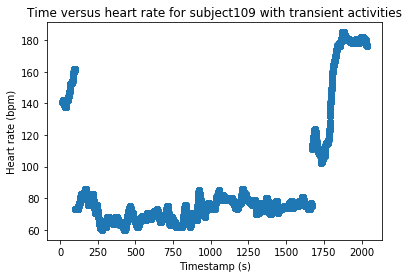

In [73]:
plt.scatter(s9.timestamp, s9.heart_rate)
plt.title("Time versus heart rate for subject109 with transient activities")
plt.xlabel("Timestamp (s)")
plt.ylabel("Heart rate (bpm)")

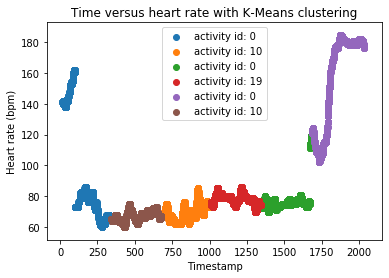

In [74]:
clusters(s9nonan, 6)

We can see that the plot of time versus heart rate for subject109 with transient activities included is slightly different to our original that we clustered over, with some extra data. We drop NaN values of course before clustering.

We can see that our clustering model is broken completely with this additional data. This is because the data where activityID = 0 is hidden among other activities with no clear trend of its own and so gets incorrectly clustered with other labelled activities by our model. 

We now modify our original clusters function once again to account for this. We have our activities vector with all of the activities for labelled cluster. We then filter the zeros out of this and take the first value, giving our normal clustering result. We then take all of the values that are zeros and count them, meaning that we can see how many zeros are included for each normal activity. We see this below:

In [75]:
def testclusters(df, num_clusters):
    clf = cluster.KMeans(init = "random", n_clusters = num_clusters)
    clf.fit(df[["timestamp", "heart_rate"]])
    df["cluster"] = clf.predict(df[["timestamp", "heart_rate"]])
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        activities = df.loc[df['cluster'] == n, 'activityid']
        activity = activities[activities != 0].iloc[0]
        zeros = activities[activities == 0].count()
        plt.scatter(clustered_df['timestamp'], clustered_df['heart_rate'], label = 'activity id = {} and zeros = {}'.format(activity, zeros))
    plt.legend()
    plt.title("Time versus heart rate K-means clustering with transient activities")
    plt.xlabel("Timestamp")
    plt.ylabel("Heart rate (bpm)")
    plt.show()

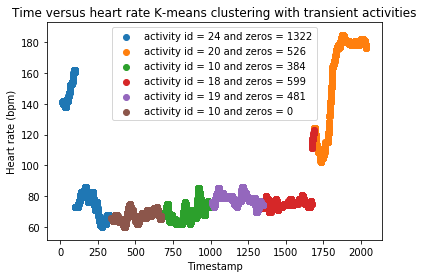

In [76]:
testclusters(s9nonan, 6)

While it is not completely correct, this model deals with the noise that comes with transient activities being included in the data.

### Subject103 clustering

As mentioned in the clustering section, here is original clustering with subject103. We will check if the labelling of activities is consistent with the true activities.

In [77]:
sub3nonan = sub3.dropna()

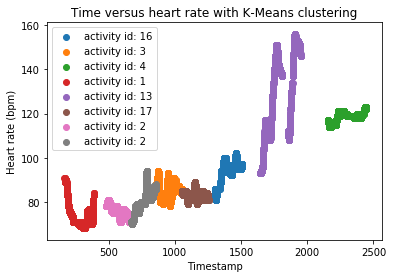

In [78]:
clusters(sub3nonan, 8)

In [79]:
clf = cluster.KMeans(init = "random", n_clusters = 5)
clf.fit(sub3nonan[["timestamp", "heart_rate"]])
prediction3 = clf.predict(sub3nonan[["timestamp", "heart_rate"]])
s=silhouette_score(sub3nonan[["timestamp", "heart_rate"]],prediction3) # calculate silhouette score
print("Silhouette score for subject103 K-means clustering: {}".format(s))

Silhouette score for subject103 K-means clustering: 0.6134463278303113


In [80]:
#15841 rows, 8 clusters = 1980.125 cluster values each. 15841 not divisible by 8 so add on two extra cluster values of 7. 
#Provides some inaccuracy but shouldn't affect the score too much.
perfectcluster = [0]*1980 + [1]*1980 + [2]*1980 + [3]*1980 + [4]*1980 + [5]*1980 + [6]*1980 + [7]*1981
a=adjusted_rand_score(perfectcluster,clf.predict(sub3nonan[["timestamp", "heart_rate"]])) # calculate adjusted rand score
print("Adjusted rand score for subject 103 K-means clustering: {}".format(a))

Adjusted rand score for subject 103 K-means clustering: 0.49277511295865245


Sihloutte score is not bad, although adjusted rand score is not very good.

In [81]:
newsub3 = sub3.filter(['timestamp','activityid'], axis=1)

In [82]:
newsub3[newsub3["timestamp"] > 100].head(1) #Correct

,timestamp,activityid
16047,166.11,1


In [83]:
newsub3[newsub3["timestamp"] > 500].head(1)  #Correct

,timestamp,activityid
49437,500.01,2


In [84]:
newsub3[newsub3["timestamp"] > 900].head(1) #Correct

,timestamp,activityid
89437,900.01,3


In [85]:
newsub3[newsub3["timestamp"] > 1250].head(1) #Correct

,timestamp,activityid
124437,1250.01,17


In [86]:
newsub3[newsub3["timestamp"] > 1400].head(1) #Correct

,timestamp,activityid
139437,1400.01,16


In [87]:
newsub3[newsub3["timestamp"] > 1600].head(1) #Correct

,timestamp,activityid
163545,1641.09,13


In [88]:
newsub3[newsub3["timestamp"] > 1700].head(1) #Not correct

,timestamp,activityid
170396,1709.6,12


In [89]:
newsub3[newsub3["timestamp"] > 2000].head(1) #Correct

,timestamp,activityid
214720,2152.84,4


Hence it seems that activity 12 is being incorrectly labelled as activity 13. Overall only one cluster is being mislabelled out of eight. 

### Acceleration and heart rate clustering

Text(0.5, 0, 'Heart rate (bpm)')

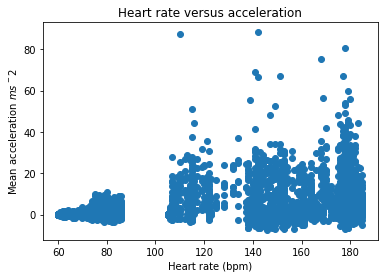

In [90]:
plt.scatter(sub9nonan["heart_rate"] ,sub9nonan["acceleration"])
plt.title("Heart rate versus acceleration")
plt.ylabel("Mean acceleration $ms^-2$")
plt.xlabel("Heart rate (bpm)")

In [91]:
def newaccelerationclusters(df, num_clusters):
    clf = cluster.KMeans(init = "random", n_clusters = num_clusters)
    clf.fit(df[["heart_rate", "acceleration"]])
    df["cluster"] = clf.predict(df[["heart_rate", "acceleration"]])
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        activity = df.loc[df['cluster'] == n, 'activityid'].iloc[0]
        plt.scatter(clustered_df['heart_rate'], clustered_df['acceleration'], label = 'activity id: '+str(activity))
    plt.legend()
    plt.title("Heart rate versus acceleration with K-Means clustering")
    plt.xlabel("Heart rate")
    plt.ylabel("Mean acceleration ($ms^{-2}$)")
    plt.show()

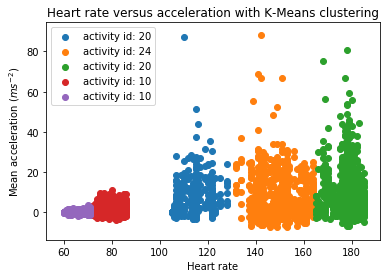

In [92]:
newaccelerationclusters(sub9nonan, 5)

The results for this clustering model were subpar, although I did not opt to do the same for Agglomerative clustering which could have given better results.